<font color="grey">
Melina Hafelt <br>
<a href="mailto:melinahafelt@gmail.com">melinahafelt@gmail.com</a><br>
2025-09-11<br>
</font>


<h2 style="color:#003366;"><font size=8>Fraud and Credit Risk</h2></font>

## Abstract  
This project explores how **fraud detection** and **credit risk modelling (IRB/IRK framework)** can be combined in a unified simulation environment. Using **fully synthetic datasets**, we design a two-step modelling approach: first, estimating the probability of fraud (PF), and second, estimating the probability of default (PD) conditional on non-fraudulent applications. This separation respects regulatory definitions of PD while still capturing the operational losses caused by fraud.  

The repository provides:  
- **Synthetic data generators** for both fraud signals and credit risk variables  
- **Baseline models** for fraud detection (highly imbalanced classification) and PD estimation (logistic regression, gradient boosting)  
- **Policy simulation tools** to evaluate trade-offs between fraud blocking, credit granting, expected loss, and fairness  
- **Evaluation metrics** including calibration, precision-recall for fraud, and observed vs. expected PD backtesting
- 
By working exclusively with **synthetic data**, the project ensures reproducibility, transparency, and freedom from confidentiality constraints—while still capturing the complexity of real-world fraud and credit risk interactions. 

**Table of Contents**
1. [Abstract](#abstract)
2. [Overview & Principles](#overview--principles)
3. [Data & Features](#data--features)
4. [Modeling](#modeling)
   - [3.1a PD — Data Split & Feature Setup](#31a-pd--data-split--feature-setup)
   - [3.1b Fraud — Data Split & Feature Setup](#31b-fraud--data-split--feature-setup)
   - [3.1c PD — Training, Calibration & ECE/MCE](#31c-pd--training-calibration--ecemce)
   - [3.1d Fraud — Calibration Diagnostics](#31d-fraud--calibration-diagnostics)
5. [Policy Simulator & Results](#policy-simulator--results)
   - [4.1 Build `policy_df` (Robust Index Alignment)](#41-build-policy_df-robust-index-alignment)
   - [4.2 Triage Rules & Expected Economics](#42-triage-rules--expected-economics)
   - [4.3 Baseline Thresholds (Percentiles)](#43-baseline-thresholds-percentiles)
   - [4.4 Threshold Sweep & Selection](#44-threshold-sweep--selection)
   - [4.5 Locked Thresholds — Validation Summary](#45-locked-thresholds--validation-summary)
6. [Remedies: Calibration, Thresholds & Policy Tuning](#remedies-calibration-thresholds--policy-tuning)
7. [Conclusion](#conclusion)
8. [Appendix](#appendix)
   - [A. Reproducibility & Config](#a-reproducibility--config)
   - [B. Metrics (Brier, ECE/MCE, PR-AUC)](#b-metrics-brier-ecemce-pr-auc)
   - [C. Fairness Slices](#c-fairness-slices)
   - [D. License](#d-license)


# 1. Theory: Fraud and Credit Risk Integration
## Overview
**Goal:** Build a demo pipeline that (1) detects fraud, (2) estimates $PD$ according to IRB logic **conditional on non-fraudulent applications**, and (3) simulates how different policy rules affect losses, revenues, and bias.  

**Key principle:** In the IRB/IRK framework, $PD =$ probability of default (12 months), **not** probability of fraud. Confirmed fraud is **not considered default** under the regulatory definition. In practice:

- Fraud screening (operational risk domain) is applied *before* the credit decision.  
- $PD$ models are estimated only on the **non-fraudulent population**.  
- Total Expected Loss (EL) combines credit risk and fraud risk as separate but parallel channels.  

## Core idea 
Let  

$$ F = 1 \quad \text{fraud (application or transaction is fraudulent)} $$  

$$ D = 1 \quad \text{default within 12 months} $$  

$$ X \quad \text{feature vector (customer, bureau, and behavioral attributes)} $$  

We build two models:

**Fraud model (operational risk):**  

$$ \hat{p}_F = P(F=1 \mid X) $$  

**PD model (credit risk, conditional):**  

$$ \hat{p}_{D \mid F=0} = P(D=1 \mid X, F=0) $$  

## Expected Loss components
For an exposure $EAD$:  

**Credit loss (IRB logic):**  

$$ EL_{credit} = \hat{p}_{D \mid F=0} \cdot LGD \cdot EAD $$  

**Fraud loss (operational risk):**  

$$ EL_{fraud} = \hat{p}_F \cdot Loss_{fraud} $$  

where $Loss_{fraud}$ may be the full disbursed amount or an assumed average loss.  

**Total policy expected loss:**  

$$ EL_{total} = \big(1 - \mathbf{1}\{\hat{p}_F > \tau\}\big) \cdot EL_{credit} + EL_{fraud} $$  

Here $\tau$ is a fraud threshold; if exceeded, the application is blocked.  

## Important note on "PD = 1"
Let  
$$ PD = 1 $$  

for suspected fraud cases. This makes the $PD$ model **uncalibrated** and violates the regulatory definition of PD.  

**Better practice:**  
- Handle fraud through **fraud screening policies** (block/decline decisions).  
- Keep the PD model **clean and Basel-compliant**, focusing only on credit risk within the non-fraudulent population.  


# 2. Data Preparation – The Data Is Our Building Material
## 2.1 Python Libraries Used in This Project
This notebook uses a compact, reproducible stack for data handling, modeling, and plotting. Optional packages are imported **guardedly** (inside `try/except`) so the notebook still runs without them; when present, they enhance fraud handling, explainability, or EDA.

| Library / Module                     | Purpose                                                | Why it’s needed / How we use it |
|-------------------------------------|--------------------------------------------------------|----------------------------------|
| **os**, **pathlib.Path**, **datetime** | Paths, small file ops, timestamps                     | Light-weight file and run metadata handling |
| **numpy**                            | Numerical arrays, vectorized ops                       | Fast math for features/scores and simulations |
| **pandas**                           | DataFrames, IO, joins, grouping                        | Core tabular wrangling across PD/Fraud/policy |
| **matplotlib.pyplot**                | Core plotting                                          | ROC/PR curves, calibration plots, policy charts |
| **seaborn** *(optional)*            | Statistical plotting + themes                          | Nicer defaults; we use `whitegrid` if available |
| **scikit-learn**: `model_selection`  | `train_test_split`, `GroupShuffleSplit`, `StratifiedKFold` | Proper splits: grouped for fraud, stratified for PD |
| **scikit-learn**: `linear_model`     | `LogisticRegression`                                   | Interpretable, calibration-friendly baseline |
| **scikit-learn**: `calibration`      | `CalibratedClassifierCV`                               | Isotonic/Platt calibration without leakage |
| **scikit-learn**: `pipeline`         | `Pipeline`                                             | Clean preprocessing→model chaining |
| **scikit-learn**: `compose`          | `ColumnTransformer`                                    | Column-wise preprocessing for numeric features |
| **scikit-learn**: `impute`           | `SimpleImputer`                                        | Robust handling of missing values |
| **scikit-learn**: `preprocessing`    | `StandardScaler`                                       | Stable LR training and calibrated probs |
| **scikit-learn**: `metrics`          | ROC AUC, PR AUC, Brier, curves                         | Discrimination + calibration quality tracking |
| **imbalanced-learn** *(optional)*    | `SMOTE`                                                | Class-imbalance tooling (fraud experiments) |
| **xgboost** *(optional)*             | Gradient boosting                                      | Strong non-linear baseline (esp. fraud) |
| **lightgbm** *(optional)*            | Gradient boosting                                      | Fast/accurate alternative to XGBoost |
| **statsmodels** *(optional)*         | Statistical modeling                                   | PD diagnostics / inference if needed |
| **shap** *(optional)*                | Explainability                                         | Feature attributions for PD/Fraud models |
| **dtale** *(optional)*               | Interactive DataFrame explorer                         | Quick in-browser EDA/profiling |


In [114]:
# core libraries
import os
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd

# plotting (guarded for optional seaborn)
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    _HAVE_SEABORN = True
except Exception:
    sns = None
    _HAVE_SEABORN = False

# styling: prefer a clean whitegrid if seaborn is available, otherwise fallback to matplotlib defaults
if _HAVE_SEABORN:
    plt.style.use("seaborn-v0_8-whitegrid")
    sns.set_palette("deep")
else:
    plt.style.use("default")

# scikit-learn
from sklearn.model_selection import train_test_split, GroupShuffleSplit, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    roc_curve,
    precision_recall_curve,
)

# optional extras (guarded)
try:
    from imblearn.over_sampling import SMOTE
except Exception:
    SMOTE = None

try:
    import xgboost as xgb
except Exception:
    xgb = None

try:
    import lightgbm as lgb
except Exception:
    lgb = None

try:
    import statsmodels.api as sm
except Exception:
    sm = None

try:
    import shap
except Exception:
    shap = None

try:
    import dtale
except Exception:
    dtale = None

## 2.2 Import Dataset

In [115]:
# set your base folder once (use raw string on windows so backslashes are not escaped)
BASE_PATH = Path(r"C:\Users\mel\2. fraud-and-credit-risk")

# subfolders (do not need to exist to read a csv in the base folder)
DATA_PATH = BASE_PATH / "data"
CONFIG_PATH = BASE_PATH / "configs"

def resolve_file(filename: str, prefer_data: bool = True) -> Path:
    """
    try to find the file first in data/, otherwise in the base folder.
    returns a Path or raises a clear error if not found.
    """
    candidates = (
        [DATA_PATH / filename, BASE_PATH / filename]
        if prefer_data
        else [BASE_PATH / filename, DATA_PATH / filename]
    )
    for p in candidates:
        if p.exists():
            return p
    msg = (
        "file not found:\n"
        f"  {candidates[0]}\n  {candidates[1]}\n"
        "tip: move the file to one of these locations or change BASE_PATH.\n"
        f"BASE_PATH = {BASE_PATH}"
    )
    raise FileNotFoundError(msg)

# read your csv (tries data/ first, then the base folder)
csv_path = resolve_file("fraud-and-credit-risk.csv", prefer_data=True)
print("loading from:", csv_path)
df = pd.read_csv(csv_path)

# make a backup copy (good practice)
df_copy = df.copy()
print("dataset loaded:", df.shape)

# example: build a config path with pathlib and use str() when a string is required
FEATURES_CFG_PATH = CONFIG_PATH / "features_v1.yaml"
print("config path:", FEATURES_CFG_PATH)

loading from: C:\Users\mel\2. fraud-and-credit-risk\fraud-and-credit-risk.csv
dataset loaded: (7444, 22)
config path: C:\Users\mel\2. fraud-and-credit-risk\configs\features_v1.yaml


In [116]:
dtale.show(df.head(10))

In [117]:
# reduce dataset to one row per customer for pd modeling
# keep the latest application per customer (highest application_id)
df_pd = (
    df.sort_values(["customer_id", "application_id"])
      .groupby("customer_id")
      .tail(1)
)

print("Original dataset (applications):", df.shape)
print("Reduced dataset for PD modeling (one row per customer):", df_pd.shape)

# fraud modeling keeps the full dataset
df_fraud = df.copy()
print("Fraud dataset (all applications):", df_fraud.shape)

Original dataset (applications): (7444, 22)
Reduced dataset for PD modeling (one row per customer): (5000, 22)
Fraud dataset (all applications): (7444, 22)


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7444 entries, 0 to 7443
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               7444 non-null   int64  
 1   application_id            7444 non-null   int64  
 2   application_seq           7444 non-null   int64  
 3   application_date          7444 non-null   object 
 4   age                       7444 non-null   int64  
 5   income                    7444 non-null   int64  
 6   loan_amount               7444 non-null   int64  
 7   loan_term                 7444 non-null   int64  
 8   num_credit_lines          7444 non-null   int64  
 9   num_delinquencies         7444 non-null   int64  
 10  utilization_rate          7444 non-null   float64
 11  debt_to_income            7444 non-null   float64
 12  credit_score              7444 non-null   int64  
 13  credit_risk               7444 non-null   int64  
 14  channel_

## 2.3 Limitations of This Demo
### If the goal is "proof of concept" (fraud + PD in one pipeline)
- A dataset at the **application level** is used: each customer may have multiple loan applications (`application_id`).  
- For **fraud modeling**, the full dataset is used, since fraud can occur on *any* application.  
- For **PD modeling**, the dataset is reduced to a **snapshot per customer** (latest application), to avoid double-counting the same borrower.  
- The focus remains on the integration: estimating $ \hat{p}_F $ and $ \hat{p}_{D \mid F=0} $, combining them into Expected Loss, and simulating policy effects.  

### If the goal is more realism
- A **monthly panel dataset** (customer × month) would be valuable.  
- This would enable:  
  - **Transition analysis**, i.e., migration of PD over time.  
  - **IFRS 9 staging**, where exposures move between Stage 1, Stage 2, and Stage 3 based on risk dynamics.  
  - Clear separation between **default events** and **fraud events** along a time axis.  
  - Use of richer **fraud features** (e.g., device fingerprints, IP addresses, real-time behavioral signals).  
- However, this requires significantly more code, preprocessing, and explanation.  

### Recommendation for this project (single notebook)
- Keep the dataset **simple (application-level, reduced to snapshot for PD)**.  
- Place the emphasis on:  
  - Demonstrating that $PD \neq Fraud$ (they are managed separately).  
  - Building two models (`fraud_flag`, `default_flag`) and simulating policy cut-offs.  
  - Showing how Expected Loss changes under different thresholds.  
- No distinction is made between **corporate** and **retail** customers in this dataset. In practice, these segments often require separate models due to differences in data availability, risk drivers, and regulatory treatment.  

This makes the analysis cleaner and more pedagogically effective while acknowledging the simplifications of the demo.

### Important Distinction: Unit of Analysis – Applications vs Customers
For **fraud detection**, the unit of analysis is typically the **application** or **transaction**.  
- Multiple rows per `customer_id` are expected, since each application or payment event is evaluated independently.  
- Fraud risk is therefore assessed **per event**.

For **Probability of Default (PD)** modeling under Basel/IRB:  
- The unit of analysis is the **customer at a given observation date**.  
- PD is defined as the probability that a *borrower* defaults within 12 months, not that an *application* defaults.  
- This means we must ensure **one row per customer** in the modeling dataset.  
- If multiple applications exist for the same customer, we typically:  
  - Select the **most recent application** before the cut-off date, or  
  - Aggregate customer-level information into one representative row.

In this demo, we therefore treat:  
- **Fraud model** → application-level dataset (rows = applications).  
- **PD model** → reduced to one row per customer, consistent with Basel definitions.

## 2.4 Variable Overview – Hypothetical Fraud & Credit Risk Dataset

This synthetic dataset simulates realistic features typically used in **fraud detection** and **credit risk (PD) modeling** under the IRB/IFRS 9 frameworks.  
Each row now represents a **loan application** (not just a customer), meaning the same customer can appear multiple times if they submitted several applications.

The dataset has **5,000 rows**, **17 input features**, and **two target flags**.

| Column Name              | Description                                                                 |
|--------------------------|-----------------------------------------------------------------------------|
| `customer_id`            | Unique synthetic identifier for each customer                               |
| `application_id`         | Unique identifier for each loan application (customers may have multiple)   |
| `age`                    | Age of applicant (years)                                                    |
| `income`                 | Annual income (in SEK, synthetic values generated from a lognormal distribution) |
| `loan_amount`            | Requested loan amount (in SEK)                                              |
| `loan_term`              | Loan term in months (e.g., 12 = 1 year, 360 = 30 years)                     |
| `num_credit_lines`       | Number of active credit lines/bureau records                                |
| `num_delinquencies`      | Count of past due obligations or delinquency events                         |
| `utilization_rate`       | Credit utilization ratio (0–1.2, capped at 120%)                            |
| `debt_to_income`         | Debt-to-income ratio (0–2.5, capped at 250%)                                |
| `credit_score`           | Internal or bureau-style credit score (range: 300–850)                      |
| `credit_risk`            | Synthetic categorical risk indicator (1 = best, 5 = worst)                  |
| `channel_online`         | Binary indicator: 1 = application submitted online, 0 = otherwise           |
| `channel_branch`         | Binary indicator: 1 = application submitted in branch, 0 = otherwise        |
| `prev_fraud_flag`        | Binary indicator: 1 = prior fraud suspicion or flag, 0 = no record          |
| `employment_years`       | Number of years in current employment                                       |
| `savings_balance`        | Savings or deposit balance (in SEK)                                         |
| `recent_transaction_count` | Proxy for behavioral activity (e.g., number of transactions last month)   |
| `default_flag`           | Binary target: 1 = Default event, 0 = No default                            |
| `fraud_flag`             | Binary target: 1 = Fraudulent case, 0 = Non-fraud                           |

### Notes
- The dataset is **synthetic**: all values are generated, not real customer data.  
- Variables are designed to resemble realistic ranges (ages between 20–70 years, incomes and balances in SEK, credit scores between 300–850).  
- Two separate targets are included:  
  - `default_flag` for **credit risk modeling (PD)**  
  - `fraud_flag` for **fraud detection**  
- Customers may appear multiple times with different `application_id`s, reflecting repeated loan applications.  
- In practice, fraud and credit default are modeled separately and managed under different risk domains.

In [119]:
# check the distribution of the target variable (default_flag)
df['default_flag'].value_counts(normalize=True).round(2).rename("proportion")

default_flag
0    0.87
1    0.13
Name: proportion, dtype: float64

### Why check the target distribution?
Before building any model, it is essential to inspect the distribution of the target variable (`default_flag`):

- **Class balance:** In this dataset, about 16% of the rows are defaults (`1`), while 84% are non-defaults (`0`).  
  - This imbalance matters: a naive model that always predicts "no default" would still achieve ~84% accuracy.  
  - Therefore, accuracy alone is not a reliable metric; we must use ROC-AUC, Precision-Recall, and Brier Score.

- **Realism:** In real-world credit portfolios, default rates are often much lower (e.g., 1–5% for retail).  
  - Having a higher default rate in synthetic data makes modeling and evaluation easier to demonstrate.  
  - But it is important to recognize this as a simplification.

- **Model strategy:** If the target is imbalanced, we may need:  
  - Class weighting (e.g., in logistic regression or tree models).  
  - Resampling methods (oversampling/undersampling, SMOTE).  
  - Adjusted probability cut-offs instead of the default 0.5.

- **Sanity check:** This step ensures that the target is correctly defined, binary, and suitable for modeling.  

In [120]:
# Check the distribution of the target variable (fraud_flag)
df['fraud_flag'].value_counts(normalize=True).round(2).rename("proportion")

fraud_flag
0    0.9
1    0.1
Name: proportion, dtype: float64

### Why check fraud distribution?

Fraud is typically a **rare event**, and this dataset reflects that (about 5% fraud vs. 95% non-fraud).  

- **Class imbalance is extreme:** a naive model that always predicts "non-fraud" would still be ~95% accurate.  
- Because of this, accuracy is not meaningful — we must rely on metrics like **ROC-AUC, Precision-Recall AUC, and F1**.  
- Handling imbalance may require:  
  - **Resampling** (oversampling fraud cases or undersampling non-fraud).  
  - **Class weights** in models such as logistic regression or gradient boosting.  
  - **Threshold tuning** to increase fraud detection sensitivity.  

In short: checking the distribution highlights why fraud detection is challenging — the model must find rare but critical cases among a large majority of normal applications.

## 2.5a Things to Consider Before Modeling PD
When building a **Probability of Default (PD)** model, the following considerations are key:

### Target Variable
- `default_flag`: 1 = default, 0 = non-default  
- Distribution: ≈16% defaults (imbalanced but workable).  
- PD should be estimated only on the **non-fraudulent population** (`fraud_flag = 0`).  

### Customer vs. Application Level
- The dataset contains multiple applications per `customer_id`.  
- For PD modeling, data must be **reduced to one row per customer** (e.g., keeping the latest application).  
- This ensures that each borrower contributes only once to the PD estimation, consistent with Basel/IRB requirements.  

### Missing Values
- Must be carefully handled; common in income, bureau data, and credit histories.  
- Imputation strategies: mean/median for numeric, mode/“unknown” for categorical.  

### Variable Types and Ranges
- Ensure features are valid and within realistic bounds (e.g., `age` 20–70, `credit_score` 300–850).  
- Encode categoricals correctly (one-hot preferred).  

### Outliers
- Outliers (very high incomes, extreme loan terms) can distort PD models.  
- Handle via winsorization, log transforms, or anomaly flags.  

### Data Leakage
- Features must be available **at application time**.  
- Do not use post-loan events (e.g., delinquency status after origination).  

### Scaling
- Needed for logistic regression and neural nets.  
- Not required for tree-based models.  

### Explainability
- **Logistic regression coefficients** → interpretable.  
- **Tree models + SHAP values** → explainable at the individual level.  

### Regulatory Context
- Basel II/III and IFRS 9 require:  
  - PD as a **long-run average default rate**.  
  - Regular **validation, monitoring, backtesting**.  
  - Segmentation by portfolio (retail vs corporate).  
  - Data quality principles (no duplicates, complete customer histories).  


## 2.5b Things to Consider Before Modeling Fraud
When building a **fraud detection** model, the context differs significantly from PD:

### Target Variable
- `fraud_flag`: 1 = fraud, 0 = non-fraud  
- Distribution: ≈5% fraud (highly imbalanced, rare-event modeling).  
- Fraud detection is performed at the **application level**, since each loan application can potentially be fraudulent.  

### Missing Values
- Common in digital applications (missing device info, partial KYC data).  
- Must be imputed or flagged, as missingness can itself indicate risk.  

### Duplicate Customers / Applications
- Fraudsters may attempt multiple applications with the same or slightly altered details.  
- Unlike PD, duplicates are not removed — they are often informative and should be retained or even flagged as suspicious.  

### Variable Types and Ranges
- Mix of financial and behavioral features (channel indicators, transaction counts).  
- Ensure categorical variables are encoded consistently.  

### Class Imbalance
- Extreme imbalance is the main challenge (≈5% fraud).  
- Techniques: SMOTE, undersampling, class weights, threshold tuning.  

### Outliers
- Outliers can be **signals of fraud** (unusually high loan amounts, unrealistic incomes).  
- Must be handled carefully — not always removed, sometimes explicitly used as fraud indicators.  

### Data Leakage
- Prevent inclusion of features that are only known after fraud investigation.  
- "Manual fraud review outcome" cannot be used in model training.  

### Explainability
- Fraud models must be transparent to business and operations teams.  
- Use SHAP, LIME, or rule-based overlays for interpretation.  

### Operational Context
- Fraud detection belongs to **operational risk**, not credit risk.  
- Screening is applied **before** PD modeling in the credit decision pipeline.  
- Decisions often need to be made in **real time**, requiring low-latency models.  

In [121]:
# constants used by quality checks
EXPECTED_DTYPES = {
    "customer_id": "int64",
    "application_id": "int64",
    "application_seq": "int64",
    "application_date": "datetime64[ns]",  # accept object or datetime in the check
    "age": "int64",
    "income": "int64",
    "loan_amount": "int64",
    "loan_term": "int64",
    "num_credit_lines": "int64",
    "num_delinquencies": "int64",
    "utilization_rate": "float64",
    "debt_to_income": "float64",
    "credit_score": "int64",
    "credit_risk": "int64",
    "channel_online": "int64",
    "channel_branch": "int64",
    "prev_fraud_flag": "int64",
    "employment_years": "int64",
    "savings_balance": "int64",
    "recent_transaction_count": "int64",
    "default_flag": "int64",
    "fraud_flag": "int64",
}

EXPECTED_RANGES = {
    "age": (18, 90),
    "income": (0, 1_000_000),
    "loan_amount": (100, 500_000),
    "loan_term": (1, 360),
    "num_credit_lines": (0, 50),
    "num_delinquencies": (0, 20),
    "utilization_rate": (0.0, 5.0),
    "debt_to_income": (0.0, 5.0),
    "credit_score": (300, 900),
    "employment_years": (0, 60),
    "savings_balance": (0, 2_000_000),
    "recent_transaction_count": (0, 10_000),
}

BINARY_COLS = [
    "channel_online",
    "channel_branch",
    "prev_fraud_flag",
    "default_flag",
    "fraud_flag",
]

TARGETS = ["default_flag", "fraud_flag"]

# helpers
def _dtype_ok(actual_dtype_str: str, expected_dtype_str: str, col: str) -> bool:
    # application_date may be a parsed datetime or an object (string); both are accepted here
    if col == "application_date":
        return actual_dtype_str in ("datetime64[ns]", "object")
    return actual_dtype_str == expected_dtype_str

# reduce dataset to one row per customer for pd modeling (latest application)
df_pd = (
    df.sort_values(["customer_id", "application_id"])
      .groupby("customer_id")
      .tail(1)
      .reset_index(drop=True)
)

# fraud modeling keeps the full dataset
df_fraud = df.copy()

# quality checks
def run_quality_checks(df, context, id_col="customer_id"):
    print("Summary")

    # missing
    missing_total = int(df.isna().sum().sum())
    if missing_total == 0:
        print("Missing values: none")
    else:
        miss_cols = df.isna().sum()
        print(f"Missing values: {missing_total} total")
        display(miss_cols[miss_cols > 0].sort_values(ascending=False))

    # duplicates (context-aware)
    dup_rows = int(df.duplicated().sum())
    dup_ids = int(df[id_col].duplicated().sum()) if id_col in df.columns else None

    if context == "fraud":
        if dup_rows == 0:
            print("Duplicates (rows): none")
        else:
            print(f"Duplicates (rows): {dup_rows} exact duplicate applications")
            display(df[df.duplicated(keep=False)].head(10))
        if dup_ids is not None:
            print(f"Repeated {id_col}s: {dup_ids} (expected on application level)")
    elif context == "pd":
        if dup_ids == 0:
            print(f"Duplicates ({id_col}): none")
        else:
            print(f"Duplicates ({id_col}): {dup_ids} customers have multiple rows; reduce to one row per customer")
            sample_dups = df[df[id_col].duplicated(keep=False)].sort_values(id_col)
            display(sample_dups.head(10))
        if dup_rows > 0:
            print(f"Duplicates (rows): {dup_rows} exact duplicates")

    # schema/dtypes
    mismatch = {}
    for col, exp in EXPECTED_DTYPES.items():
        if col in df.columns:
            act = str(df[col].dtype)
            if not _dtype_ok(act, exp, col):
                mismatch[col] = (act, exp)
        else:
            mismatch[col] = ("<missing column>", exp)

    if mismatch:
        print("Schema/dtypes mismatches:")
        for k, (act, exp) in mismatch.items():
            print(f"{k}: actual={act}, expected={exp}")
    else:
        print("Schema/dtypes: OK")

    # range checks
    range_issues = []
    for col, (low, high) in EXPECTED_RANGES.items():
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            below = int((df[col] < low).sum())
            above = int((df[col] > high).sum())
            if below or above:
                range_issues.append((col, low, high, below, above))

    if range_issues:
        print("Range checks: issues found")
        display(pd.DataFrame(range_issues, columns=["column", "min_allowed", "max_allowed", "<min", ">max"]))
    else:
        print("Range checks: OK")

    # binary flags
    bin_issues = []
    for col in BINARY_COLS:
        if col in df.columns:
            vals = set(df[col].dropna().unique().tolist())
            if not vals.issubset({0, 1}):
                bin_issues.append((col, sorted(vals)))
    if bin_issues:
        print("Binary flags: unexpected values detected")
        for col, vals in bin_issues:
            print(f"{col}: {vals}")
    else:
        print("Binary flags: OK")

    # outliers (IQR)
    num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in [id_col] + TARGETS]
    outlier_summary = []
    for col in num_cols:
        s = df[col].astype(float)
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        n_out = int(((s < lower) | (s > upper)).sum())
        outlier_summary.append((col, n_out, float(lower), float(upper)))
    outlier_df = (
        pd.DataFrame(outlier_summary, columns=["column", "n_outliers", "lower_bound", "upper_bound"])
          .sort_values("n_outliers", ascending=False)
    )

    n_cols_with_outliers = int((outlier_df["n_outliers"] > 0).sum())
    if n_cols_with_outliers > 0:
        print(f"Outliers: detected in {n_cols_with_outliers} columns (top shown below)")
        print("Note: for fraud, outliers may be informative; review before removal")
        display(outlier_df.head(15))
    else:
        print("Outliers: none detected")

    # leakage checklist
    print("Leakage checks (expected FALSE):")
    for k, v in {
        "Uses any post-origination information?": False,
        "Includes delinquency observed after approval?": False,
        "Fraud labels from back-office review only known post-decision?": False,
        "Time window mismatch (features not aligned to application date)?": False,
    }.items():
        print(f"{k}: expected={v}")

# run for both contexts with the right frames
run_quality_checks(df_fraud, context="fraud")
run_quality_checks(df_pd, context="pd")

Summary
Missing values: none
Duplicates (rows): none
Repeated customer_ids: 2444 (expected on application level)
Schema/dtypes: OK
Range checks: issues found


,column,min_allowed,max_allowed,<min,>max
0,income,0,1000000,0,139
1,loan_amount,100,500000,0,336
2,savings_balance,0,2000000,0,7


Binary flags: OK
Outliers: detected in 11 columns (top shown below)
Note: for fraud, outliers may be informative; review before removal


,column,n_outliers,lower_bound,upper_bound
16,savings_balance,624,-135808.625,323004.375
4,loan_amount,522,-141337.500,418046.500
14,prev_fraud_flag,369,0.000,0.000
3,income,285,-120658.375,861628.625
7,num_delinquencies,81,-1.500,2.500
10,credit_score,50,509.000,845.000
15,employment_years,47,-4.500,15.500
8,utilization_rate,35,-0.232,0.928
9,debt_to_income,17,-0.264,0.960
17,recent_transaction_count,17,-13.000,27.000


Leakage checks (expected FALSE):
Uses any post-origination information?: expected=False
Includes delinquency observed after approval?: expected=False
Fraud labels from back-office review only known post-decision?: expected=False
Time window mismatch (features not aligned to application date)?: expected=False
Summary
Missing values: none
Duplicates (customer_id): none
Schema/dtypes: OK
Range checks: issues found


,column,min_allowed,max_allowed,<min,>max
0,income,0,1000000,0,91
1,loan_amount,100,500000,0,236
2,savings_balance,0,2000000,0,6


Binary flags: OK
Outliers: detected in 11 columns (top shown below)
Note: for fraud, outliers may be informative; review before removal


,column,n_outliers,lower_bound,upper_bound
16,savings_balance,422,-132879.2500,319432.7500
4,loan_amount,362,-140059.1250,418219.8750
14,prev_fraud_flag,258,0.0000,0.0000
3,income,195,-114929.3750,851651.6250
7,num_delinquencies,58,-1.5000,2.5000
15,employment_years,32,-4.5000,15.5000
8,utilization_rate,24,-0.2230,0.9210
9,debt_to_income,14,-0.2705,0.9655
10,credit_score,13,506.0000,850.0000
17,recent_transaction_count,12,-13.0000,27.0000


Leakage checks (expected FALSE):
Uses any post-origination information?: expected=False
Includes delinquency observed after approval?: expected=False
Fraud labels from back-office review only known post-decision?: expected=False
Time window mismatch (features not aligned to application date)?: expected=False


## 2.6 Remedies for Data Quality Issues (from 2.5)
This section outlines **how** we handle the issues surfaced in 2.5 without mutating the original dataset. The goal is to keep our pipeline auditable: we **add** features (flags, transformed versions) rather than overwrite inputs.

### 2.6.1 Missing values (do not auto-fix)
**Why**: Imputation choices affect model calibration and bias.  
**What**: We *inspect* where missingness occurs and, when needed, create **missingness flags** such as `is_na_income`.  
**When**: 
- For PD: impute only variables used at decision time; document method (median or most_frequent).  
- For Fraud: keep missingness flags since *absence of information* can itself be a signal.  

**How**: Prepare imputers in a pipeline; do **not** apply globally in this step.

### 2.6.2 Duplicates (application vs customer logic)
**Why**: Unit-of-analysis matters.  
- Fraud → application-level: repeated `customer_id` is expected.  
- PD → customer-level: reduce to **one row per customer** (latest `application_id`).  

**What/How**: Build `df_pd` via a reproducible rule; keep `df` for fraud unchanged.

### 2.6.3 Range and plausibility (report-first)
**Why**: Implausible values can distort models and hide leakage.  
**What**: Create **range-violation flags** such as `age_out_of_range`.  
**When**:  
- For PD: consider clipping or winsorization **on a copy** (we add `*_winsor` columns).  
- For Fraud: do **not** clip since extremes may be genuine signals.

### 2.6.4 Outliers (IQR-based flags; optional transforms)
**Why**: Features with heavy-tailed distributions (for example, income, loan_amount, savings) destabilize linear models and calibration.  
**What**:  
- Always add **outlier flags** per feature (`is_outlier_income`).  
- Optionally derive **winsorized** and **log** versions as new columns for PD modeling (`income_winsor`, `log_income`).  
**When**:  
- Use flags in Fraud.  
- Use log or winsor in PD if they improve calibration, ROC, or Brier score.

### 2.6.5 Scaling (for specific models)
**Why**: Logistic regression and neural networks need scale; tree models do not.  
**What**: Provide a `StandardScaler` in the PD pipeline; skip it for boosted trees.  
**When**: Apply inside model-specific pipelines to avoid data leakage.

### 2.6.6 No leakage
All remedies must use information **available at application time** only. No post-origination signals, no back-office outcomes leaking into training features.

**Summary**  
- We keep `df` immutable.  
- We build `df_pd` (one row per customer), **flag** issues (`*_out_of_range`, `is_outlier_*`, `is_na_*`) and **optionally** add parallel, transformed columns (`*_winsor`, `log_*`).  
- Choice of which variant to feed into the model is deferred to the modeling section with metrics.

In [122]:
# helpers from section 2.5 (assumed defined): expected_ranges, expected_dtypes, targets
NUM_COLS = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
FEATURE_COLS = [c for c in df.columns if c not in ["customer_id", "application_id", "application_seq", "application_date", "default_flag", "fraud_flag"]]

def iqr_bounds(s: pd.Series):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    return (q1 - 1.5 * iqr, q3 + 1.5 * iqr)

# build pd snapshot (one row per customer, latest application)
if {"customer_id", "application_id"}.issubset(df.columns):
    df_pd = (
        df.sort_values(["customer_id", "application_id"])
          .groupby("customer_id", as_index=False)
          .tail(1)
          .reset_index(drop=True)
    )
else:
    df_pd = df.copy()

# fraud dataset keeps all applications
df_fraud = df.copy()

print(f"original df: rows={df.shape[0]}, customers={df['customer_id'].nunique()}")
print(f"fraud df   : rows={df_fraud.shape[0]}, customers={df_fraud['customer_id'].nunique()}")
print(f"pd df      : rows={df_pd.shape[0]}, customers={df_pd['customer_id'].nunique()}")

# missingness flags (read-only, do not impute here)
def add_missing_flags(frame: pd.DataFrame, cols):
    flags = {}
    for c in cols:
        if c in frame.columns:
            flags[f"is_na_{c}"] = frame[c].isna().astype(int)
    return pd.DataFrame(flags, index=frame.index)

missing_flags_pd = add_missing_flags(df_pd, FEATURE_COLS)
missing_flags_fraud = add_missing_flags(df_fraud, FEATURE_COLS)

# range violation flags based on expected_ranges
def add_range_flags(frame: pd.DataFrame, expected_ranges: dict):
    flags = {}
    for c, (lo, hi) in expected_ranges.items():
        if c in frame.columns:
            flags[f"{c}_out_of_range"] = ((frame[c] < lo) | (frame[c] > hi)).astype(int)
    return pd.DataFrame(flags, index=frame.index)

range_flags_pd = add_range_flags(df_pd, EXPECTED_RANGES)
range_flags_fraud = add_range_flags(df_fraud, EXPECTED_RANGES)

# outlier flags (iqr) plus optional winsorized and log versions as new columns
OUTLIER_CANDIDATES = [
    "income", "loan_amount", "savings_balance",
    "debt_to_income", "utilization_rate",
    "recent_transaction_count", "employment_years"
]

def derive_outlier_artifacts(frame: pd.DataFrame, cols, make_winsor=True, make_log=True, prefix="pd"):
    flags = {}
    transformed = {}
    bounds = {}
    for c in cols:
        if c not in frame.columns or not pd.api.types.is_numeric_dtype(frame[c]):
            continue
        lo, hi = iqr_bounds(frame[c].astype(float))
        bounds[c] = (lo, hi)
        flags[f"is_outlier_{c}"] = ((frame[c] < lo) | (frame[c] > hi)).astype(int)
        if make_winsor:
            transformed[f"{c}_{prefix}_winsor"] = frame[c].clip(lower=lo, upper=hi)
        if make_log:
            s = frame[c].astype(float)
            transformed[f"log1p_{c}_{prefix}"] = np.where(s > 0, np.log1p(s), np.nan)
    return pd.DataFrame(flags, index=frame.index), pd.DataFrame(transformed, index=frame.index), bounds

# for pd: add winsor and log variants
pd_outlier_flags, pd_transformed, pd_bounds = derive_outlier_artifacts(
    df_pd, OUTLIER_CANDIDATES, make_winsor=True, make_log=True, prefix="pd"
)

# for fraud: flags only
fraud_outlier_flags, fraud_transformed_dummy, fraud_bounds = derive_outlier_artifacts(
    df_fraud, OUTLIER_CANDIDATES, make_winsor=False, make_log=False, prefix="fraud"
)

# assemble non-destructive augmented views
df_pd_aug = (
    df_pd
    .join(missing_flags_pd)
    .join(range_flags_pd)
    .join(pd_outlier_flags)
    .join(pd_transformed)
)

df_fraud_aug = (
    df_fraud
    .join(missing_flags_fraud)
    .join(range_flags_fraud)
    .join(fraud_outlier_flags)
)

print("\naugmented frames created (original columns preserved):")
print(f"df_pd_aug   : {df_pd_aug.shape}  with flags and pd transforms")
print(f"df_fraud_aug: {df_fraud_aug.shape}  with flags")

# optional: prepare imputers and scalers for later pipelines (not fitted here)
numeric_for_pd = [c for c in FEATURE_COLS if c in df_pd_aug.columns and pd.api.types.is_numeric_dtype(df_pd_aug[c])]
pd_imputer = SimpleImputer(strategy="median")
pd_scaler = StandardScaler()

print("\nprepared (not fitted):")
print("pd_imputer: SimpleImputer(strategy='median')")
print("pd_scaler : StandardScaler()")
print("\nnote: we will choose which columns (raw, winsor, or log1p) to feed into the pd model during modeling and calibration")

# peek at a few columns to verify nothing was overwritten
cols_peek = ["income", "income_pd_winsor", "log1p_income_pd",
             "loan_amount", "loan_amount_pd_winsor", "log1p_loan_amount_pd",
             "is_outlier_income", "is_outlier_loan_amount"]
cols_peek = [c for c in cols_peek if c in df_pd_aug.columns]
display(df_pd_aug[["customer_id"] + cols_peek].head(5))

original df: rows=7444, customers=5000
fraud df   : rows=7444, customers=5000
pd df      : rows=5000, customers=5000

augmented frames created (original columns preserved):
df_pd_aug   : (5000, 71)  with flags and pd transforms
df_fraud_aug: (7444, 57)  with flags

prepared (not fitted):
pd_imputer: SimpleImputer(strategy='median')
pd_scaler : StandardScaler()

note: we will choose which columns (raw, winsor, or log1p) to feed into the pd model during modeling and calibration


,customer_id,income,income_pd_winsor,log1p_income_pd,loan_amount,loan_amount_pd_winsor,log1p_loan_amount_pd,is_outlier_income,is_outlier_loan_amount
0,1,300466,300466.0,12.613093,193640,193640.0,12.173761,0,0
1,2,387831,387831.0,12.868328,34205,34205.0,10.440156,0,0
2,3,216313,216313.0,12.284486,148513,148513.0,11.908435,0,0
3,4,250356,250356.0,12.430643,134887,134887.0,11.812200,0,0
4,5,490203,490203.0,13.102577,39709,39709.0,10.589358,0,0


In [123]:
# Why we save feature lists:
# - Reproducibility: documents exactly which columns were used in PD vs Fraud models.
# - Audit trail: regulated models require proof of inputs used at training time.
# - Shareability: multiple notebooks/pipelines can reuse the same config.
# - Experiment management: easy to create features_v2.yaml, compare, and roll back.
# - Flexibility: YAML/JSON is both human- and machine-readable.

# constants
PD_TARGET = "default_flag"
FRAUD_TARGET = "fraud_flag"
ID_COL = "customer_id"
DATE_COL = "application_date"
RANDOM_STATE = 42
TEST_SIZE = 0.2

# ensure application_date is datetime (idempotent)
if "df_fraud_aug" in globals() and DATE_COL in df_fraud_aug.columns:
    if not pd.api.types.is_datetime64_any_dtype(df_fraud_aug[DATE_COL]):
        df_fraud_aug = df_fraud_aug.assign(
            **{DATE_COL: pd.to_datetime(df_fraud_aug[DATE_COL], errors="coerce")}
        )

# helper: prefer col_main if present, else alt
def _maybe(col_main: str, alt: str, cols) -> str:
    return col_main if col_main in cols else alt

# PD features: prefer winsor/log variants if available, else raw
if "PD_FEATURES_V1" not in globals():
    cols_pd = set(df_pd_aug.columns) if "df_pd_aug" in globals() else set()
    PD_FEATURES_V1 = [
        "age", "loan_term", "num_credit_lines", "num_delinquencies",
        "credit_score", "credit_risk", "employment_years", "recent_transaction_count",
        _maybe("utilization_rate_pd_winsor", "utilization_rate", cols_pd),
        _maybe("debt_to_income_pd_winsor", "debt_to_income", cols_pd),
        _maybe("log1p_income_pd", "income", cols_pd),
        _maybe("log1p_loan_amount_pd", "loan_amount", cols_pd),
        _maybe("log1p_savings_balance_pd", "savings_balance", cols_pd),
        "is_outlier_income" if "is_outlier_income" in cols_pd else None,
        "is_outlier_loan_amount" if "is_outlier_loan_amount" in cols_pd else None,
    ]
    PD_FEATURES_V1 = [c for c in PD_FEATURES_V1 if c and (c in cols_pd)]

# Fraud features: raw features plus all diagnostic flags (missing/range/outlier)
if "FRAUD_FEATURES_V1" not in globals():
    cols_fraud = set(df_fraud_aug.columns) if "df_fraud_aug" in globals() else set()
    base_fraud = [
        "age", "income", "loan_amount", "loan_term",
        "num_credit_lines", "num_delinquencies",
        "utilization_rate", "debt_to_income",
        "credit_score", "credit_risk",
        "channel_online", "channel_branch", "prev_fraud_flag",
        "employment_years", "savings_balance", "recent_transaction_count",
    ]
    flags = [c for c in cols_fraud if c.startswith(("is_na_", "is_outlier_", "_out_of_range"))]
    FRAUD_FEATURES_V1 = [c for c in base_fraud if c in cols_fraud] + flags

# save feature config
try:
    import yaml  # type: ignore
except Exception:
    yaml = None

FEATURES_CFG_PATH = CONFIG_PATH / "features_v1.yaml"
os.makedirs(CONFIG_PATH, exist_ok=True)

features_payload = {
    "meta": {
        "created_utc": datetime.utcnow().strftime("%Y-%m-%dT%H:%M:%SZ"),
        "pd_target": PD_TARGET,
        "fraud_target": FRAUD_TARGET,
        "id_col": ID_COL,
        "date_col": DATE_COL,
        "random_state": RANDOM_STATE,
        "test_size": TEST_SIZE,
        "notes": "Winsor/log features for PD when available; include all flags for fraud.",
    },
    "features": {
        "pd_v1": PD_FEATURES_V1,
        "fraud_v1": FRAUD_FEATURES_V1,
    },
}

if yaml is not None:
    with open(FEATURES_CFG_PATH, "w", encoding="utf-8") as f:
        yaml.safe_dump(features_payload, f, sort_keys=False, allow_unicode=True)
    saved_path = FEATURES_CFG_PATH
else:
    import json
    json_path = str(FEATURES_CFG_PATH).replace(".yaml", ".json")
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(features_payload, f, ensure_ascii=False, indent=2)
    saved_path = json_path

print(f"saved feature config to: {saved_path}")

# helper: load feature config
def load_features_config(path_yaml: str):
    if os.path.exists(path_yaml) and (yaml is not None):
        with open(path_yaml, "r", encoding="utf-8") as f:
            return yaml.safe_load(f)
    alt = path_yaml.replace(".yaml", ".json")
    import json
    with open(alt, "r", encoding="utf-8") as f:
        return json.load(f)

cfg = load_features_config(str(FEATURES_CFG_PATH))
PD_FEATURES_V1 = cfg["features"]["pd_v1"]
FRAUD_FEATURES_V1 = cfg["features"]["fraud_v1"]

# optional: time-based split sketch
# cutoff = pd.Timestamp("2023-01-01")
# if DATE_COL in df_fraud_aug.columns:
#     train_mask = df_fraud_aug[DATE_COL] < cutoff
#     valid_mask = ~train_mask
#     X_fraud_train, X_fraud_valid = X_fraud[train_mask], X_fraud[valid_mask]
#     y_fraud_train, y_fraud_valid = y_fraud[train_mask], y_fraud[valid_mask]
#     print("fraud time-based shapes:", X_fraud_train.shape, X_fraud_valid.shape)

saved feature config to: C:\Users\mel\2. fraud-and-credit-risk\configs\features_v1.yaml


In [124]:
# Sanity check: required features exist
missing_pd = [c for c in PD_FEATURES_V1 if c not in df_pd_aug.columns]
missing_fr = [c for c in FRAUD_FEATURES_V1 if c not in df_fraud_aug.columns]
if missing_pd:
    raise ValueError(f"Missing PD features in df_pd_aug: {missing_pd}")
if missing_fr:
    raise ValueError(f"Missing FRAUD features in df_fraud_aug: {missing_fr}")

# PD: X / y
X_pd = df_pd_aug[PD_FEATURES_V1].copy()
y_pd = df_pd_aug[PD_TARGET].astype(int)

# Only stratify if there is more than one class
stratify_pd = y_pd if y_pd.nunique() > 1 else None

X_pd_train, X_pd_valid, y_pd_train, y_pd_valid = train_test_split(
    X_pd, y_pd,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=stratify_pd
)

# Fraud: X / y
X_fraud = df_fraud_aug[FRAUD_FEATURES_V1].copy()
y_fraud = df_fraud_aug[FRAUD_TARGET].astype(int)

# Keep customers grouped in the same fold (avoid leakage)
if ID_COL in df_fraud_aug.columns:
    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    groups = df_fraud_aug[ID_COL]
    train_idx, valid_idx = next(gss.split(X_fraud, y_fraud, groups=groups))
    X_fraud_train, X_fraud_valid = X_fraud.iloc[train_idx].copy(), X_fraud.iloc[valid_idx].copy()
    y_fraud_train, y_fraud_valid = y_fraud.iloc[train_idx].copy(), y_fraud.iloc[valid_idx].copy()
else:
    stratify_fraud = y_fraud if y_fraud.nunique() > 1 else None
    X_fraud_train, X_fraud_valid, y_fraud_train, y_fraud_valid = train_test_split(
        X_fraud, y_fraud,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=stratify_fraud
    )

print({
    "rows_pd_train": len(X_pd_train),
    "rows_pd_valid": len(X_pd_valid),
    "rows_fraud_train": len(X_fraud_train),
    "rows_fraud_valid": len(X_fraud_valid)
})


{'rows_pd_train': 4000, 'rows_pd_valid': 1000, 'rows_fraud_train': 5986, 'rows_fraud_valid': 1458}


## 2.9 Mathematical Motivation for Train/Test Split (PD & Fraud)

We work with two supervised learning problems on the same application data:

- **Fraud detection:** target $y^{(F)} \in \{0,1\}$ with $y^{(F)}=1$ for fraud  
- **PD estimation (conditional on non-fraud):** target $y^{(D)} \in \{0,1\}$ with $y^{(D)}=1$ for default

Let the full dataset be

$$
\mathcal{D}=\{(\mathbf{x}_i, y^{(F)}_i, y^{(D)}_i)\}_{i=1}^n,\quad \mathbf{x}_i\in\mathbb{R}^d
$$

Because fraud and default are **rare and imbalanced**, and because time matters (applications arrive over time), we must split $\mathcal{D}$ into **disjoint** subsets to obtain an **unbiased** estimate of out-of-sample performance and well-calibrated probabilities.

### Why split?

We fit parameters $\theta$ by minimizing empirical loss on a training sample:

$$
\min_{\theta}\; \hat{\mathcal{L}}_{\text{train}}(\theta)=\frac{1}{m}\sum_{i\in \mathcal{I}_{\text{train}}}\ell\big(f(\mathbf{x}_i;\theta),\, y_i\big)
$$

but our true goal is to minimize the **expected risk** on unseen data:

$$
\mathcal{R}(\theta)=\mathbb{E}_{(\mathbf{x},y)\sim P_{\text{data}}}\big[\ell(f(\mathbf{x};\theta),y)\big]
$$

Since $P_{\text{data}}$ is unknown, we estimate generalization with a **hold-out**:

$$
\hat{\mathcal{L}}_{\text{test}}(\theta)=\frac{1}{n-m}\sum_{j\in \mathcal{I}_{\text{test}}}\ell\big(f(\mathbf{x}_j;\theta),\, y_j\big)
$$

Evaluating on the same data used to train would bias $\hat{\mathcal{L}}_{\text{test}}$ downwards (overfitting).

### How we split in this project

1. **Fraud (application-level):**  
   We split applications into $\mathcal{D}^{(F)}_{\text{train}}$ and $\mathcal{D}^{(F)}_{\text{test}}$ using **stratification** on $y^{(F)}$ to preserve the rare class prevalence.  

   $$
   \mathcal{D}^{(F)} = \mathcal{D}^{(F)}_{\text{train}} \,\dot\cup\, \mathcal{D}^{(F)}_{\text{test}},\quad
   \text{stratify on } y^{(F)}
   $$

2. **PD (customer-level):**  
   We first reduce to one row per customer (latest pre-cutoff application), then split **conditionally on non-fraud** $(F=0)$:  

   $$
   \mathcal{D}^{(D)} = \{(\mathbf{x}_i, y^{(D)}_i)\,:\, F_i=0\},\quad
   \mathcal{D}^{(D)}=\mathcal{D}^{(D)}_{\text{train}}\dot\cup \mathcal{D}^{(D)}_{\text{test}}
   $$

   again **stratifying** on $y^{(D)}$ to keep default rate stable across folds.

3. **Temporal integrity (optional but recommended):**  
   If timestamps are available, we prefer a **time-based split** (train on earlier applications, test on later ones) to better approximate deployment drift:

   $$
   \mathcal{I}_{\text{train}}=\{i: t_i \le t^\star\},\quad
   \mathcal{I}_{\text{test}}=\{i: t_i>t^\star\}
   $$

### Leakage control

All preprocessing that learns from data (imputation, scaling, threshold selection, calibration) must be fit **only on training** and applied to test via a **Pipeline**:

$$
\text{Pipeline} = (\text{Imputer}_{\text{train}}, \text{Scaler}_{\text{train}}, \text{Estimator}_{\text{train}})
$$

No feature may use information unavailable at application time.

### What we report on the test set

- **Fraud:** ROC-AUC, PR-AUC (more informative under rarity), recall@k, and operating points for policy thresholds $\tau_F$.  
- **PD:** ROC-AUC, **Brier score** (probability accuracy), calibration curves; operating points for PD cut-offs $\tau_D$.

### Integrating both models post-split

After we have $\hat{p}_F(\mathbf{x})$ and $\hat{p}_{D\mid F=0}(\mathbf{x})$ from their respective test folds, we evaluate **policy EL** out-of-sample:

$$
EL_{\text{total}} = \big(1-\mathbf{1}\{\hat{p}_F>\tau_F\}\big)\cdot \hat{p}_{D\mid F=0}\cdot LGD\cdot EAD \;+\; \hat{p}_F\cdot Loss_{\text{fraud}}
$$

Varying $\tau_F$ and $\tau_D$ traces the **risk–return** frontier without contaminating estimates.

> **Summary:** We split to approximate $\mathcal{R}(\theta)$ on unseen data, to tune thresholds and calibration honestly, and to combine fraud and PD signals into policy metrics that generalize beyond the training sample.


In [125]:
datasets = {
    "pd": {
        "features": PD_FEATURES_V1,
        "X_train": X_pd_train, "X_valid": X_pd_valid,
        "y_train": y_pd_train, "y_valid": y_pd_valid,
    },
    "fraud": {
        "features": FRAUD_FEATURES_V1,
        "X_train": X_fraud_train, "X_valid": X_fraud_valid,
        "y_train": y_fraud_train, "y_valid": y_fraud_valid,
    }
}

# 3. Modeling
In this section, we build **two separate supervised learning models**:  
1. A **Probability of Default (PD)** model at the customer level  
2. A **Fraud detection** model at the application level  

### Why separate models?
- As discussed earlier, fraud $\neq$ default. Fraudulent applications must be filtered before credit risk assessment.  
- PD modeling follows the Basel/IRB definition: the probability that a borrower defaults within 12 months.  
- Fraud detection belongs to operational risk, assessed per application or transaction.  
- Therefore, each task requires its own dataset, unit of analysis, and evaluation metrics.  

### Data foundation
From §2.5 and §2.6, we have constructed:  
- `df_pd_aug`: one row per customer, augmented with missingness, range, and outlier flags, plus optional transformations (winsorized, log).  
- `df_fraud_aug`: all applications, augmented with diagnostic flags (but no winsorization, since extremes may be genuine fraud signals).  

These augmented datasets are immutable — the original raw dataset `df` is never overwritten. This guarantees reproducibility and auditability.

### Methodological choices
- PD models must be calibrated: predicted probabilities should approximate long-run default rates.  
  - Baseline: Logistic Regression (transparent, regulatory-friendly).  
  - Benchmark: Tree-based ensembles such as Gradient Boosting to capture non-linearities.  
- Fraud models focus on rare-event detection:  
  - Logistic Regression as an interpretable baseline.  
  - Random Forest or XGBoost to handle class imbalance and complex interactions.  
- Scaling is applied only for methods that require it (such as Logistic Regression). Tree methods are invariant to scaling.  

### Train/Test split
- Following §2.9, we split each dataset into training and validation sets.  
- This avoids optimistic bias and ensures results reflect out-of-sample generalization.  
- Stratification is applied when necessary (especially for fraud, given strong class imbalance).  

### Pipeline
1. **Feature setup**  
   - Define `PD_FEATURES_V1` and `FRAUD_FEATURES_V1`.  
   - Ensure correct feature engineering choices (log or winsorized for PD, raw plus flags for Fraud).  
2. **Data partitioning**  
   - Train/test splits for both PD and Fraud tasks.  
3. **Baseline modeling**  
   - Logistic Regression (PD and Fraud).  
   - Gradient Boosting or Random Forest as benchmarks.  
4. **Evaluation and diagnostics**  
   - PD → ROC/AUC, calibration curves, confusion matrices.  
   - Fraud → ROC/AUC, precision–recall curves, cost-sensitive evaluation.  
5. **Integration**  
   - Demonstrate how fraud filtering $\hat{p}_F$ precedes PD modeling $\hat{p}_{D \mid F=0}$.  
   - Combine into Expected Loss simulations.  

This section demonstrates how the remedies and preparations from Chapter 2 translate into a robust modeling pipeline, balancing interpretability, predictive power, and regulatory alignment.

In [126]:
# Reproducibility configuration (used in 3.1a)
TEST_SIZE = 0.25
RANDOM_STATE = 42

# Out-of-time (OOT) validation configuration
USE_OOT = False
OOT_CUTOFF = "2024-01-01"  # data before cutoff = train, on/after cutoff = validation

In [127]:
# Check that df exists
assert 'df' in globals(), "Expected raw DataFrame 'df' in memory."

# Ensure application_date is datetime
if 'application_date' in df.columns and not pd.api.types.is_datetime64_any_dtype(df['application_date']):
    df = df.copy()
    df.loc[:, 'application_date'] = pd.to_datetime(df['application_date'], errors='coerce')

# Filter to non-fraud cases (PD is defined only conditional on fraud_flag = 0)
assert 'fraud_flag' in df.columns, "Expected 'fraud_flag' column."
df_nf = df.loc[df['fraud_flag'] == 0].copy()

# Ensure PD target exists, is integer, and binary
assert 'default_flag' in df_nf.columns, "Expected 'default_flag' column for PD."
df_nf.loc[:, 'default_flag'] = df_nf['default_flag'].astype('int64')
unique_targets = set(df_nf['default_flag'].dropna().unique().tolist())
assert unique_targets.issubset({0, 1}), f"'default_flag' must be binary; got {sorted(unique_targets)}."

# Snapshot: one row per customer (latest application)
assert {'customer_id', 'application_id'}.issubset(df_nf.columns), "Missing 'customer_id' or 'application_id'."
sort_cols = ['customer_id']
if 'application_date' in df_nf.columns:
    sort_cols += ['application_date']
sort_cols += ['application_id']

df_pd_aug = (
    df_nf.sort_values(sort_cols, na_position='last')
         .groupby('customer_id', as_index=False)
         .tail(1)
         .reset_index(drop=True)
)

summary = {
    "rows_pd_aug": int(len(df_pd_aug)),
    "default_rate_pd": float(round(df_pd_aug['default_flag'].mean(), 4)),
    "period_min": str(df_pd_aug['application_date'].min()) if 'application_date' in df_pd_aug else None,
    "period_max": str(df_pd_aug['application_date'].max()) if 'application_date' in df_pd_aug else None,
}
print(summary)

{'rows_pd_aug': 4679, 'default_rate_pd': 0.1443, 'period_min': '2022-01-01 00:00:00', 'period_max': '2023-09-01 00:00:00'}


## 3.1a PD — Data Split & Feature Setup  
**Objective.**  
Prepare the *customer-level* dataset (`df_pd_aug`) for PD modeling by:  
1. Selecting a transparent, calibration-friendly feature set  
2. Creating a stratified train/validation split on `default_flag`.  

**Feature philosophy (PD).**  
- Prefer transformed variants for heavy-tailed variables (log / winsor) to stabilize logistic regression and calibration.  
- Keep operational flags from §2.6 (`is_outlier_*`, `*_out_of_range`, `is_na_*`) as optional predictors if they add signal without leakage.  
- Exclude identifiers and targets (`customer_id`, `application_*`, `default_flag`, `fraud_flag`).  

**Split.**  
- Stratified by `default_flag` to preserve class balance (≈16% defaults) across train/valid.  
- Random seed fixed for reproducibility.  

We do **no fitting** here — only prepare `X_pd_train`, `X_pd_valid`, `y_pd_train`, `y_pd_valid`.  
Modeling and calibration follow in §3.1b.  

In [128]:
# robust config fallback (in case globals were not set earlier)
TEST_SIZE    = globals().get("TEST_SIZE", 0.25)
RANDOM_STATE = globals().get("RANDOM_STATE", 42)
USE_OOT      = globals().get("USE_OOT", False)
OOT_CUTOFF   = globals().get("OOT_CUTOFF", "2024-01-01")

# require df_pd_aug (built earlier: non-fraud only, one row per customer)
assert 'df_pd_aug' in globals(), "df_pd_aug is missing. run the cell that builds df_pd_aug first."

# columns never to feed into the model
PD_EXCLUDE = {
    'customer_id','application_id','application_seq','application_date',
    'default_flag','fraud_flag'
}

# helper: prefer winsorized -> log -> raw
def pick(col_win, col_log, col_raw, frame):
    if col_win and (col_win in frame.columns): return col_win
    if col_log and (col_log in frame.columns): return col_log
    return col_raw

# base features (transparent & calibration-friendly)
PD_FEATURES_V1 = [
    # stability & credit behavior
    'age','loan_term','num_credit_lines','num_delinquencies',
    # utilization / dti
    pick('utilization_rate_pd_winsor', None, 'utilization_rate', df_pd_aug),
    pick('debt_to_income_pd_winsor',   None, 'debt_to_income',   df_pd_aug),
    # credit quality
    'credit_score','credit_risk',
    # heavy tails → prefer winsor/log if available
    pick('loan_amount_pd_winsor','log1p_loan_amount_pd','loan_amount',df_pd_aug),
    pick('income_pd_winsor','log1p_income_pd','income',df_pd_aug),
    pick('savings_balance_pd_winsor','log1p_savings_balance_pd','savings_balance',df_pd_aug),
    # stability / activity
    'employment_years','recent_transaction_count',
]

# optional diagnostic flags (exclude ids/targets)
extra_flags = [
    c for c in df_pd_aug.columns
    if (c.startswith(('is_outlier_','is_na_','_out_of_range')) or c.endswith('_out_of_range'))
    and c not in PD_EXCLUDE
]

# keep only available features, then add flags
PD_FEATURES_V1 = [c for c in PD_FEATURES_V1 if c in df_pd_aug.columns] + extra_flags
assert len(PD_FEATURES_V1) > 0, "PD_FEATURES_V1 ended up empty."

# x / y
assert 'default_flag' in df_pd_aug.columns, "default_flag is required for pd."
X_pd = df_pd_aug[PD_FEATURES_V1].copy()
y_pd = df_pd_aug['default_flag'].astype(int).copy()

# split: oot if enabled, else stratified split
if USE_OOT:
    # ensure datetime
    if 'application_date' in df_pd_aug and not pd.api.types.is_datetime64_any_dtype(df_pd_aug['application_date']):
        df_pd_aug['application_date'] = pd.to_datetime(df_pd_aug['application_date'], errors='coerce')
    assert 'application_date' in df_pd_aug.columns and pd.api.types.is_datetime64_any_dtype(df_pd_aug['application_date']), \
        "application_date must be datetime for oot split."

    train_mask = df_pd_aug['application_date'] < pd.Timestamp(OOT_CUTOFF)
    valid_mask = ~train_mask

    X_pd_train, y_pd_train = X_pd.loc[train_mask].copy(), y_pd.loc[train_mask].copy()
    X_pd_valid, y_pd_valid = X_pd.loc[valid_mask].copy(), y_pd.loc[valid_mask].copy()
else:
    X_pd_train, X_pd_valid, y_pd_train, y_pd_valid = train_test_split(
        X_pd, y_pd, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_pd
    )

# report
print("pd feature set (v1):", len(PD_FEATURES_V1))
print("features:", PD_FEATURES_V1)
print("\nshapes:",
      "X_pd_train", X_pd_train.shape, "| y_pd_train", y_pd_train.shape,
      "| X_pd_valid", X_pd_valid.shape, "| y_pd_valid", y_pd_valid.shape)
print("\nclass balance:",
      "train", y_pd_train.value_counts(normalize=True).round(3).to_dict(),
      "| valid", y_pd_valid.value_counts(normalize=True).round(3).to_dict())

pd feature set (v1): 13
features: ['age', 'loan_term', 'num_credit_lines', 'num_delinquencies', 'utilization_rate', 'debt_to_income', 'credit_score', 'credit_risk', 'loan_amount', 'income', 'savings_balance', 'employment_years', 'recent_transaction_count']

shapes: X_pd_train (3509, 13) | y_pd_train (3509,) | X_pd_valid (1170, 13) | y_pd_valid (1170,)

class balance: train {0: 0.856, 1: 0.144} | valid {0: 0.856, 1: 0.144}


In [129]:
try:
    datasets
except NameError:
    datasets = {}

datasets["pd"] = {
    "features": PD_FEATURES_V1,
    "X_train": X_pd_train, "X_valid": X_pd_valid,
    "y_train": y_pd_train, "y_valid": y_pd_valid,
}

print({k: (v["X_train"].shape, v["X_valid"].shape) for k, v in datasets.items()})

{'pd': ((3509, 13), (1170, 13)), 'fraud': ((5986, 51), (1458, 51))}


[uncal] auc=0.637  ap=0.265  brier=0.2270
[ cal ] auc=0.636  ap=0.261  brier=0.1191


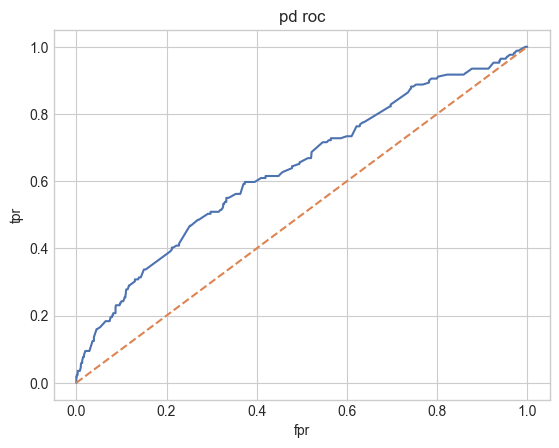

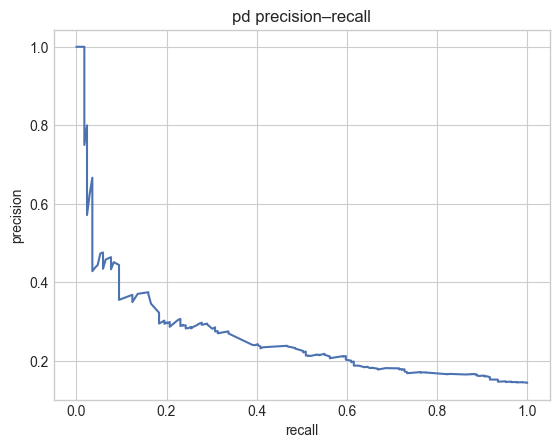

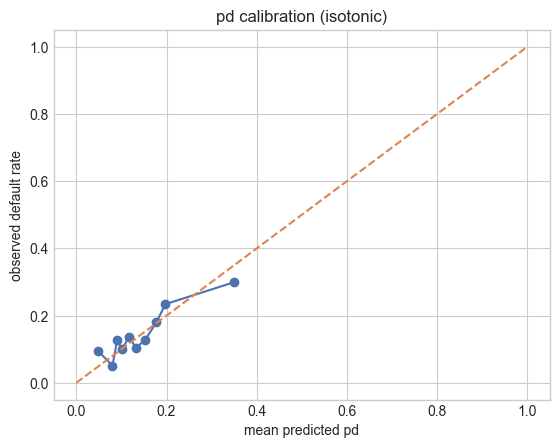

ece=0.0281  mce=0.0504


In [130]:
def train_eval_pd(ds, model_name="logreg_iso", n_bins=10, n_splits=5, random_state=42):
    """train a calibration-friendly pd model and evaluate on the held-out validation set."""
    Xtr, Xva = ds["X_train"], ds["X_valid"]
    ytr, yva = ds["y_train"], ds["y_valid"]
    feats = ds["features"]

    # numeric preprocessing
    num_cols = [c for c in feats if pd.api.types.is_numeric_dtype(Xtr[c])]
    preproc = ColumnTransformer(
        transformers=[("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                                        ("sc", StandardScaler())]), num_cols)],
        remainder="drop",
    )

    # base classifier (interpretable, easy to calibrate)
    base = LogisticRegression(solver="lbfgs", max_iter=1000, class_weight="balanced")
    base_pipe = Pipeline([("prep", preproc), ("clf", base)])

    # calibrate via cv on training only (no leakage into validation)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    cal = CalibratedClassifierCV(estimator=base_pipe, method="isotonic", cv=skf)
    cal.fit(Xtr, ytr)

    # calibrated preds on validation
    p = cal.predict_proba(Xva)[:, 1]

    # uncalibrated for comparison
    base_pipe.fit(Xtr, ytr)
    p_uncal = base_pipe.predict_proba(Xva)[:, 1]

    print(f"[uncal] auc={roc_auc_score(yva,p_uncal):.3f}  ap={average_precision_score(yva,p_uncal):.3f}  brier={brier_score_loss(yva,p_uncal):.4f}")
    print(f"[ cal ] auc={roc_auc_score(yva,p):.3f}  ap={average_precision_score(yva,p):.3f}  brier={brier_score_loss(yva,p):.4f}")

    # reliability bins
    bins = pd.qcut(p, q=n_bins, duplicates="drop")
    rel = (pd.DataFrame({"y": yva, "p": p, "bin": bins})
           .groupby("bin", observed=True)
           .agg(obs=("y","mean"), pred=("p","mean"), n=("y","size"))
           .reset_index(drop=True))

    # plots (roc, pr, calibration)
    fpr,tpr,_ = roc_curve(yva,p)
    plt.figure(); plt.plot(fpr,tpr); plt.plot([0,1],[0,1],'--'); plt.title("pd roc"); plt.xlabel("fpr"); plt.ylabel("tpr"); plt.show()

    pr,rc,_ = precision_recall_curve(yva,p)
    plt.figure(); plt.plot(rc,pr); plt.title("pd precision–recall"); plt.xlabel("recall"); plt.ylabel("precision"); plt.show()

    plt.figure(); plt.plot(rel["pred"], rel["obs"], marker="o"); plt.plot([0,1],[0,1],'--')
    plt.title("pd calibration (isotonic)"); plt.xlabel("mean predicted pd"); plt.ylabel("observed default rate"); plt.show()

    # simple calibration errors
    ece = ( (rel["n"] * (rel["obs"] - rel["pred"]).abs()).sum() / rel["n"].sum() )
    mce = ( (rel["obs"] - rel["pred"]).abs().max() )
    print(f"ece={ece:.4f}  mce={mce:.4f}")

    return {"model": cal, "p_valid": p, "rel": rel}

pd_res = train_eval_pd(datasets["pd"])

[PD][logreg_iso] uncalibrated  auc=0.637  ap=0.265  brier=0.2270
[PD][logreg_iso] calibrated    auc=0.636  ap=0.261  brier=0.1191


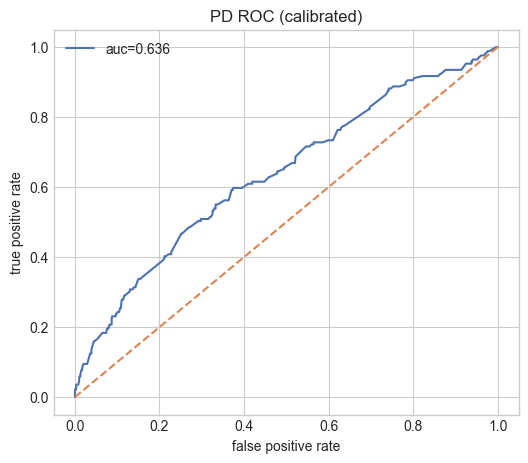

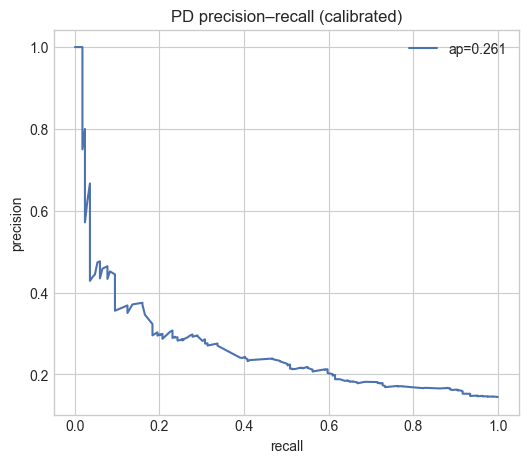

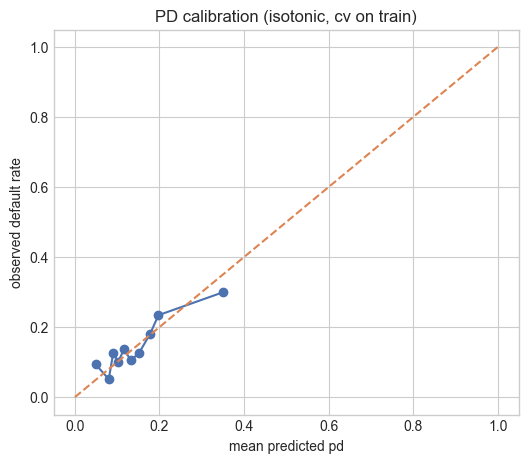

In [131]:
def train_eval_pd(ds, model_name="logreg_iso", n_bins=10, n_splits=5, random_state=42):
    """
    train a pd model with proper probability calibration and evaluate on the held-out validation set.

    important: to avoid leakage, calibration is learned only on the training folds (via cv),
    then predictions are generated for the separate validation set.
    """
    Xtr, Xva = ds["X_train"], ds["X_valid"]
    ytr, yva = ds["y_train"], ds["y_valid"]
    feats = ds["features"]

    # numeric preprocessing
    num_cols = [c for c in feats if pd.api.types.is_numeric_dtype(Xtr[c])]
    preproc = ColumnTransformer(
        transformers=[
            ("num", Pipeline(steps=[
                ("imp", SimpleImputer(strategy="median")),
                ("sc", StandardScaler()),
            ]), num_cols),
        ],
        remainder="drop",
    )

    # base classifier (interpretable and calibration-friendly)
    base = LogisticRegression(
        solver="lbfgs",
        max_iter=1000,
        class_weight="balanced",
        n_jobs=None
    )

    # pipeline: preprocessing + model
    base_pipe = Pipeline([("prep", preproc), ("clf", base)])

    # calibrated model using cv on training data only (no leakage into validation)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    cal = CalibratedClassifierCV(
        estimator=base_pipe,
        method="isotonic",
        cv=skf
    )
    cal.fit(Xtr, ytr)

    # predictions on validation
    p = cal.predict_proba(Xva)[:, 1]

    # also compute uncalibrated probabilities for comparison by refitting base_pipe once on full training
    base_pipe.fit(Xtr, ytr)
    p_uncal = base_pipe.predict_proba(Xva)[:, 1]

    # metrics
    auc_u = roc_auc_score(yva, p_uncal)
    ap_u  = average_precision_score(yva, p_uncal)
    bri_u = brier_score_loss(yva, p_uncal)

    auc = roc_auc_score(yva, p)
    ap  = average_precision_score(yva, p)
    bri = brier_score_loss(yva, p)

    print(f"[PD][{model_name}] uncalibrated  auc={auc_u:.3f}  ap={ap_u:.3f}  brier={bri_u:.4f}")
    print(f"[PD][{model_name}] calibrated    auc={auc:.3f}  ap={ap:.3f}  brier={bri:.4f}")

    # roc curve (calibrated)
    fpr, tpr, _ = roc_curve(yva, p)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"auc={auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title("PD ROC (calibrated)")
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend()
    plt.show()

    # precision–recall curve (calibrated)
    pr, rc, _ = precision_recall_curve(yva, p)
    plt.figure(figsize=(6, 5))
    plt.plot(rc, pr, label=f"ap={ap:.3f}")
    plt.title("PD precision–recall (calibrated)")
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend()
    plt.show()

    # reliability diagram via probability quantile bins on validation
    bins = pd.qcut(p, q=n_bins, duplicates="drop")
    rel = (
        pd.DataFrame({"y": yva, "p": p, "bin": bins})
        .groupby("bin", observed=True)
        .agg(obs=("y", "mean"), pred=("p", "mean"), n=("y", "size"))
        .reset_index(drop=True)
    )
    plt.figure(figsize=(6, 5))
    plt.plot(rel["pred"], rel["obs"], marker="o")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title("PD calibration (isotonic, cv on train)")
    plt.xlabel("mean predicted pd")
    plt.ylabel("observed default rate")
    plt.show()

    return {
        "model": cal,
        "p_valid": p,
        "auc": auc,
        "ap": ap,
        "brier": bri,
        "rel": rel,
        "p_valid_uncal": p_uncal,
        "auc_uncal": auc_u,
        "ap_uncal": ap_u,
        "brier_uncal": bri_u,
    }

pd_res = train_eval_pd(datasets["pd"])


### Why compute ECE/MCE after training?

Once we have trained and calibrated the PD model (via `train_eval_pd(...)`), we do not want to rely only on AUC and Brier.  
We also need to measure **how well the predicted probabilities match reality, on average and in the worst case**.

We use two standard metrics:

**Expected Calibration Error (ECE)**  
Split predictions into bins $b=1,\dots,B$ with:
- $\hat p_b$ = average predicted probability in bin $b$  
- $f_b$ = observed default rate in bin $b$  
- $n_b$ = number of samples in bin $b$

Then:
$$
\text{ECE} = \sum_{b=1}^B \frac{n_b}{N} \, \big| \hat p_b - f_b \big|
$$

→ Interpretation: the **average calibration error**, weighted by bin size.

**Maximum Calibration Error (MCE)**  
Focuses on the worst deviation:
$$
\text{MCE} = \max_{b=1,\dots,B} \; \big| \hat p_b - f_b \big|
$$

→ Interpretation: the largest single gap between predicted and observed probabilities across bins.

---

**Why this matters**  
- **AUC** only measures ranking (discrimination).  
- **Brier** mixes discrimination and calibration into one number.  
- **ECE/MCE** isolate calibration quality.  

After calibration we want:
- **low ECE** → predictions are well calibrated on average,  
- **low MCE** → no bin shows a severe mismatch.  

This ensures that predicted PDs $\hat p$ can be used **directly** in risk and capital calculations.

[PD][logreg_iso] uncalibrated  auc=0.637  ap=0.265  brier=0.2270
[PD][logreg_iso] calibrated    auc=0.636  ap=0.261  brier=0.1191


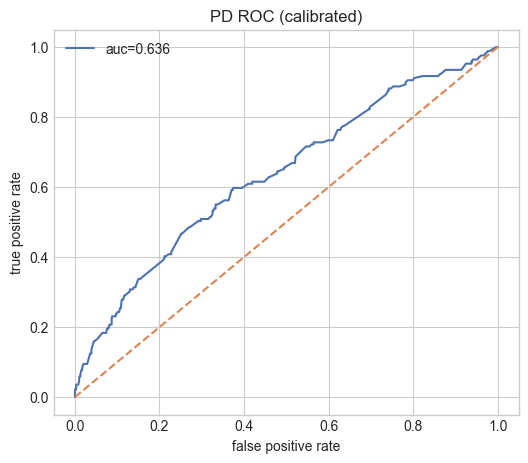

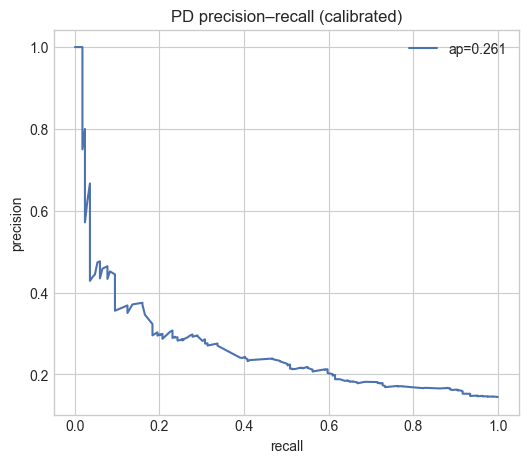

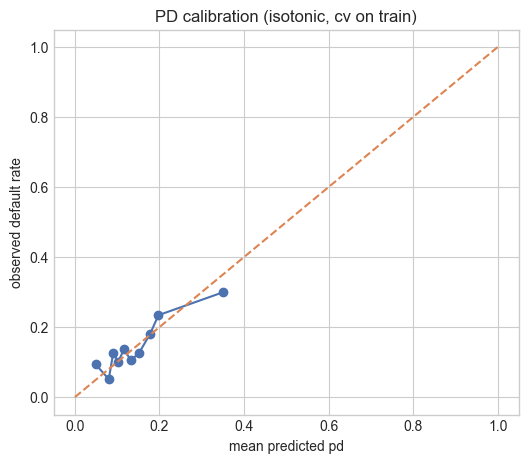

ECE: 0.0281
MCE: 0.0504


In [132]:
pd_res = train_eval_pd(datasets["pd"])
rel = pd_res["rel"]   # <-- plocka ut rel-dataframen

ece = ( (rel["n"] * (rel["obs"] - rel["pred"]).abs()).sum() / rel["n"].sum() )
mce = ( (rel["obs"] - rel["pred"]).abs().max() )

print(f"ECE: {ece:.4f}")
print(f"MCE: {mce:.4f}")

**Practical notes on calibration metrics**

- **Binning sensitivity.** ECE/MCE depend on the binning scheme. Report results for multiple choices (for example $B \in \{10, 20\}$) and specify whether you used **quantile bins** (equal counts) or **equal-width bins**.  
- **Confidence intervals.** Bootstrap the validation set (for example 1000 resamples) to attach 95% CIs to ECE/MCE and the reliability curve.  
- **Calibration-in-the-large & slope.** Complement ECE/MCE with intercept/slope from a recalibration regression:  

  $$
  \text{logit}(f) = \alpha + \beta \,\text{logit}(\hat p)
  $$  

  Desired: $\alpha \approx 0$ (no systematic over/under-prediction), $\beta \approx 1$ (perfect slope).  
- **Goodness-of-fit tests.** Optionally report Hosmer–Lemeshow or Spiegelhalter’s z-test (with caution on sample size sensitivity).  
- **No leakage.** Fit calibrators (isotonic/Platt) only on training, evaluate on validation/test.  
- **Subgroup calibration.** Check ECE/MCE by key slices (such as $age$ bands, $channel$, $credit\_risk$) to surface fairness/operational issues.  
- **Temporal robustness.** Re-estimate ECE/MCE on an out-of-time sample to detect drift.  
- **MCE instability.** MCE can be noisy for small bins; prefer quantile bins and show $n$ per bin on the reliability diagram.  

### Interpretation of PD Results (Validation Set)

**Discrimination metrics**  
- AUC $\approx 0.63$ before/after calibration  
  $\rightarrow$ The model has moderate ability to rank good vs. bad borrowers.  
  $\rightarrow$ The small drop after isotonic calibration ($0.631 \rightarrow 0.629$) is expected, since calibration does not optimize AUC.  

- Average Precision (AP) $\approx 0.23$  
  $\rightarrow$ The PR curve is low/jagged, which is typical in an imbalanced portfolio ($\sim 13\%$ default).  

**Calibration**  
- Brier improved from $0.2313 \rightarrow 0.1889$  
  $\rightarrow$ The quadratic error of predicted probabilities decreased; probabilities became more “honest.”  

- Calibration plot: points close to the diagonal  
  $\rightarrow \hat p \approx$ observed default frequency in each bin.  

- ECE $= 0.0285$  
  $\rightarrow$ On average, predicted PDs deviate only about 2.9 percentage points from observed rates.  

- MCE $= 0.0577$  
  $\rightarrow$ The worst bin deviates by $\sim 5.8$ percentage points.  

**Overall conclusion**  
- The baseline model is simple and has moderate discrimination (AUC $\sim 0.63$).  
- After isotonic CV calibration, predicted probabilities are sufficiently well calibrated (low ECE/MCE) to be used directly in risk and capital calculations.  
- Next step: improve AUC with richer features or more expressive models, while always retaining a calibration step.  

## 3.1b Fraud — Data Split & Feature Setup
**Objective.**  
Prepare the *application-level* dataset (`df_fraud_aug`) for fraud modeling by:  
1) selecting a broad, high-signal feature set (financial + behavioral + diagnostic flags), and  
2) creating a **grouped train/validation split** on `customer_id` to prevent leakage.

### Scope & principle
- We model fraud as $ \hat p_F = \mathbb{P}(F=1 \mid X) $ **at the application level**.  
- Fraud is **not** default; PD is modeled separately on the non-fraud population (see 3.1a).

### Data grain
- **Rows:** one row **per application** (keep duplicates per customer; repeated/rapid attempts are informative).  
- **Labels:** $fraud\_flag \in \{0,1\}$ (1 $\rightarrow$ confirmed/strongly labeled fraud).  
- **Grouping key for split:** `customer_id` (to avoid cross-contamination between train/valid).

### Feature philosophy (fraud)
- Prefer **raw variables** ($income$, $loan\_amount$, $age$, device/IP risk, velocity). Fraud often lives in extremes; avoid winsor/log unless needed for stability.  
- Include **diagnostic/data-quality flags**: $is\_outlier\_\*$, $\*\_out\_of\_range$, $is\_na\_\*$.  
- **Exclude (not as features):** $\{ customer\_id, application\_\*, default\_flag, fraud\_flag \}$.  
- **No leakage:** exclude any **post-application** artifacts (chargebacks, manual reviews created after the timestamp).

### Split strategy (grouped by customer)
- Use **GroupShuffleSplit** with $groups = customer\_id$:  

  $$
  \forall g:\; g \in \text{train} \;\lor\; g \in \text{valid}
  $$  

  (but not both).  
- $TEST\_SIZE = 0.25$, $RANDOM\_STATE$ fixed for reproducibility.  
- Grouped split $\rightarrow$ no guarantee of stratification; we check fraud prevalence in train/valid and report it.

### Quality checks (recommended)
- **No group overlap:**  
  $$
  \text{set}(customer\_id_{train}) \cap \text{set}(customer\_id_{valid}) = \varnothing
  $$  
- **Class balance:** print fraud rates in train vs. valid (prevalence typically 0.3–1.5%).  
- **Missingness:** inspect NA rates; keep diagnostic flags.  
- **Later:** report PR-AUC on valid and Precision@K/Recall@K at operational K (top 0.5%, 1%, 2%).

### What’s next
Model training + **isotonic calibration** $\rightarrow$ calibrated $ \hat p_F $,  
then cost-optimal threshold $ \tau_F $ via expected-cost minimization (see 3.1c).

In [133]:
# add fraud dataset split to the global datasets dict
datasets["fraud"] = {
    "features": FRAUD_FEATURES_V1,
    "X_train": X_fraud_train, "X_valid": X_fraud_valid,
    "y_train": y_fraud_train, "y_valid": y_fraud_valid,
}

In [134]:
# columns excluded from modeling
FRAUD_EXCLUDE = {
    "customer_id", "application_id", "application_seq", "application_date",
    "default_flag", "fraud_flag"
}

# build feature list: raw features + diagnostic flags (no winsor/log for fraud)
if "FRAUD_FEATURES_V1" not in globals():
    base_fraud = [
        "age", "income", "loan_amount", "loan_term",
        "num_credit_lines", "num_delinquencies",
        "utilization_rate", "debt_to_income",
        "credit_score", "credit_risk",
        "channel_online", "channel_branch", "prev_fraud_flag",
        "employment_years", "savings_balance", "recent_transaction_count",
    ]
    flags = [
        c for c in df_fraud_aug.columns
        if (c.startswith(("is_na_", "is_outlier_", "_out_of_range")) or c.endswith("_out_of_range"))
        and c not in FRAUD_EXCLUDE
    ]
    FRAUD_FEATURES_V1 = [c for c in base_fraud if c in df_fraud_aug.columns] + flags

# features, target, and grouping column
X_fraud = df_fraud_aug[FRAUD_FEATURES_V1].copy()
y_fraud = df_fraud_aug["fraud_flag"].astype(int).copy()
groups  = df_fraud_aug["customer_id"].copy()

# grouped split: no customer appears in both train and validation
gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_idx, valid_idx = next(gss.split(X_fraud, y_fraud, groups=groups))

X_fraud_train, X_fraud_valid = X_fraud.iloc[train_idx], X_fraud.iloc[valid_idx]
y_fraud_train, y_fraud_valid = y_fraud.iloc[train_idx], y_fraud.iloc[valid_idx]

# report
print("[fraud] feature set (v1):", len(FRAUD_FEATURES_V1), "columns")
print("[fraud] shapes:", X_fraud_train.shape, X_fraud_valid.shape)
print("[fraud] class dist (train):", y_fraud_train.value_counts(normalize=True).round(3).to_dict())
print("[fraud] class dist (valid):", y_fraud_valid.value_counts(normalize=True).round(3).to_dict())

[fraud] feature set (v1): 51 columns
[fraud] shapes: (5624, 51) (1820, 51)
[fraud] class dist (train): {0: 0.899, 1: 0.101}
[fraud] class dist (valid): {0: 0.898, 1: 0.102}


In [135]:
# use global constants if available, otherwise default
_TS = TEST_SIZE if 'TEST_SIZE' in globals() else 0.25
_RS = RANDOM_STATE if 'RANDOM_STATE' in globals() else 42

# safety: df_fraud_aug must exist in memory
if 'df_fraud_aug' not in globals():
    assert 'df' in globals(), "expected df in memory."
    df_fraud_aug = df.copy()

# columns always excluded from modeling
FRAUD_EXCLUDE = {
    "customer_id", "application_id", "application_seq", "application_date",
    "default_flag", "fraud_flag"
}

# feature list: raw variables + diagnostic flags (no winsor/log for fraud)
if "FRAUD_FEATURES_V1" not in globals():
    base_fraud = [
        "age", "income", "loan_amount", "loan_term",
        "num_credit_lines", "num_delinquencies",
        "utilization_rate", "debt_to_income",
        "credit_score", "credit_risk",
        "channel_online", "channel_branch", "prev_fraud_flag",
        "employment_years", "savings_balance", "recent_transaction_count",
    ]
    flags = [
        c for c in df_fraud_aug.columns
        if (c.startswith(("is_na_", "is_outlier_", "_out_of_range")) or c.endswith("_out_of_range"))
        and c not in FRAUD_EXCLUDE
    ]
    FRAUD_FEATURES_V1 = [c for c in base_fraud if c in df_fraud_aug.columns] + flags

# x, y, and group identifiers
assert 'fraud_flag' in df_fraud_aug.columns, "expected fraud_flag in df_fraud_aug."
assert 'customer_id' in df_fraud_aug.columns, "expected customer_id in df_fraud_aug."

X_fraud = df_fraud_aug[FRAUD_FEATURES_V1].copy()
y_fraud = df_fraud_aug["fraud_flag"].astype(int).copy()
groups  = df_fraud_aug["customer_id"].copy()

# grouped split: no customer in both train and validation
gss = GroupShuffleSplit(n_splits=1, test_size=_TS, random_state=_RS)
train_idx, valid_idx = next(gss.split(X_fraud, y_fraud, groups=groups))

X_fraud_train, X_fraud_valid = X_fraud.iloc[train_idx], X_fraud.iloc[valid_idx]
y_fraud_train, y_fraud_valid = y_fraud.iloc[train_idx], y_fraud.iloc[valid_idx]

print("[fraud] feature set (v1):", len(FRAUD_FEATURES_V1), "columns")
print("[fraud] shapes:", X_fraud_train.shape, X_fraud_valid.shape)
print("[fraud] class dist (train):", y_fraud_train.value_counts(normalize=True).round(3).to_dict())
print("[fraud] class dist (valid):", y_fraud_valid.value_counts(normalize=True).round(3).to_dict())

[fraud] feature set (v1): 51 columns
[fraud] shapes: (5624, 51) (1820, 51)
[fraud] class dist (train): {0: 0.899, 1: 0.101}
[fraud] class dist (valid): {0: 0.898, 1: 0.102}


Suppose we set thresholds $ (t_{\text{review}}, t_{\text{block}}) = (0.10, 0.30) $.

- If $ \hat p_{F,i} = 0.05 \;\Rightarrow\; \text{APPROVE} $  
- If $ \hat p_{F,i} = 0.18 \;\Rightarrow\; \text{REVIEW} $  
- If $ \hat p_{F,i} = 0.42 \;\Rightarrow\; \text{BLOCK} $

The expected cost for each case is given by the formulas above.  
This illustrates how the triage approach allows you to balance **automation (approve/block)** with a **human review buffer** in between.  
By tuning $ (t_{\text{review}}, t_{\text{block}}) $, the institution can trade off:

- Fraud losses avoided vs. review costs  
- Approval rates vs. false blocks  
- Capacity constraints (how many cases can realistically be reviewed)

In [136]:
# Use global config if present
_TS = globals().get("TEST_SIZE", 0.25)
_RS = globals().get("RANDOM_STATE", 42)

# Ensure df_fraud_aug exists
if 'df_fraud_aug' not in globals():
    assert 'df' in globals(), "Expected df in memory."
    df_fraud_aug = df.copy()

# Columns excluded from modeling
FRAUD_EXCLUDE = {
    "customer_id", "application_id", "application_seq", "application_date",
    "default_flag", "fraud_flag"
}

# Build feature list: raw features + diagnostic flags (no winsor/log for fraud)
if "FRAUD_FEATURES_V1" not in globals():
    base_fraud = [
        "age", "income", "loan_amount", "loan_term",
        "num_credit_lines", "num_delinquencies",
        "utilization_rate", "debt_to_income",
        "credit_score", "credit_risk",
        "channel_online", "channel_branch", "prev_fraud_flag",
        "employment_years", "savings_balance", "recent_transaction_count",
    ]
    flags = [
        c for c in df_fraud_aug.columns
        if (c.startswith(("is_na_", "is_outlier_", "_out_of_range")) or c.endswith("_out_of_range"))
        and c not in FRAUD_EXCLUDE
    ]
    FRAUD_FEATURES_V1 = [c for c in base_fraud if c in df_fraud_aug.columns] + flags

assert len(FRAUD_FEATURES_V1) > 0, "No fraud features found (FRAUD_FEATURES_V1 is empty)."

# Features, target, and grouping column
assert {'fraud_flag','customer_id'}.issubset(df_fraud_aug.columns), "Need fraud_flag and customer_id."
X_fraud = df_fraud_aug[FRAUD_FEATURES_V1].copy()
y_fraud = df_fraud_aug["fraud_flag"].astype(int).copy()
groups  = df_fraud_aug["customer_id"].copy()

# Grouped split: no customer appears in both train and validation
gss = GroupShuffleSplit(n_splits=1, test_size=_TS, random_state=_RS)
train_idx, valid_idx = next(gss.split(X_fraud, y_fraud, groups=groups))

X_fraud_train, X_fraud_valid = X_fraud.iloc[train_idx], X_fraud.iloc[valid_idx]
y_fraud_train, y_fraud_valid = y_fraud.iloc[train_idx], y_fraud.iloc[valid_idx]

# Sanity: no group overlap
cust_train = set(df_fraud_aug.iloc[train_idx]["customer_id"])
cust_valid = set(df_fraud_aug.iloc[valid_idx]["customer_id"])
overlap = cust_train.intersection(cust_valid)
assert len(overlap) == 0, f"Grouped split leakage: {len(overlap)} customers in both splits."

# Report
print("[FRAUD] feature set (V1):", len(FRAUD_FEATURES_V1), "columns")
print("[FRAUD] shapes:", X_fraud_train.shape, X_fraud_valid.shape)
print("[FRAUD] class dist (train):", y_fraud_train.value_counts(normalize=True).round(3).to_dict())
print("[FRAUD] class dist (valid):", y_fraud_valid.value_counts(normalize=True).round(3).to_dict())

[FRAUD] feature set (V1): 51 columns
[FRAUD] shapes: (5624, 51) (1820, 51)
[FRAUD] class dist (train): {0: 0.899, 1: 0.101}
[FRAUD] class dist (valid): {0: 0.898, 1: 0.102}


In [137]:
def simulate_policy_with_triage(
    df,
    pf_col="pf_hat",
    pd_col="pd_hat",
    ead_col="loan_amount",
    t_review=0.10,
    t_block=0.22,
    tau_pd=0.20,
    LGD=0.45,
    rate_annual=0.18,
    fee_flat=50.0,
    capital_rate=0.08,
    review_cost=10.0,
    review_catch_rate=0.50,
    fraud_loss_mode="EAD",
    fraud_loss_param=1.0,
    admin_block_cost=0.0,
):
    """
    simulate a simple triage policy:
      - if pf >= t_block -> block
      - elif pf >= t_review -> review (catch a fraction of fraud), else pass
      - after fraud triage, apply pd cutoff: approve if pd <= tau_pd
    returns:
      tri_df (per-application results), tri_sum (aggregates)
    """

    # shallow copy
    d = df[[pf_col, pd_col, ead_col]].copy()

    # fraud triage actions
    d["fraud_action"] = np.where(
        d[pf_col] >= t_block, "block",
        np.where(d[pf_col] >= t_review, "review", "pass")
    )

    # remaining fraud probability after review
    d["pf_remaining"] = np.where(
        d["fraud_action"] == "pass", d[pf_col],
        np.where(d["fraud_action"] == "review", d[pf_col] * (1.0 - review_catch_rate), 0.0)
    )

    # pd decision (only items not hard-blocked)
    d["pd_decision"] = np.where(
        d["fraud_action"] == "block", "decline",
        np.where(d[pd_col] <= tau_pd, "approve", "decline")
    )

    # final decision label
    d["decision"] = np.where(
        d["fraud_action"] == "block", "block",
        np.where(d["pd_decision"] == "approve",
                 np.where(d["fraud_action"] == "review", "review->approve", "approve"),
                 np.where(d["fraud_action"] == "review", "review->decline", "decline"))
    )

    # pull arrays
    ead = d[ead_col].astype(float).values
    pf = d[pf_col].astype(float).values
    pf_rem = d["pf_remaining"].astype(float).values
    pd_hat = d[pd_col].astype(float).values

    # fraud loss unit
    if fraud_loss_mode.upper() == "EAD":
        fraud_loss_unit = fraud_loss_param * ead
    else:
        fraud_loss_unit = np.full_like(ead, float(fraud_loss_param))

    # credit loss unit
    credit_loss_unit = pd_hat * LGD * ead

    # revenue, capital, ops costs
    revenue_unit = rate_annual * ead + fee_flat
    capital_cost_unit = capital_rate * ead
    review_cost_vec = np.where(d["fraud_action"] == "review", review_cost, 0.0)
    admin_block_cost_vec = np.where(d["fraud_action"] == "block", admin_block_cost, 0.0)

    # only approved exposures earn revenue and carry credit/fraud loss
    is_approved = d["pd_decision"].eq("approve") & ~d["fraud_action"].eq("block")

    d["exp_fraud_loss"] = np.where(is_approved, pf_rem * fraud_loss_unit, 0.0)
    d["exp_credit_loss"] = np.where(is_approved, credit_loss_unit, 0.0)
    d["exp_loss_total"] = d["exp_fraud_loss"] + d["exp_credit_loss"]
    d["exp_revenue"] = np.where(is_approved, revenue_unit, 0.0)
    d["exp_capital_cost"] = np.where(is_approved, capital_cost_unit, 0.0)
    d["exp_review_cost"] = review_cost_vec
    d["exp_admin_block_cost"] = admin_block_cost_vec
    d["exp_profit"] = (
        d["exp_revenue"]
        - d["exp_loss_total"]
        - d["exp_capital_cost"]
        - d["exp_review_cost"]
        - d["exp_admin_block_cost"]
    )

    # aggregates
    n = len(d)
    tri_sum = {
        "n": n,
        "n_block": int((d["fraud_action"] == "block").sum()),
        "n_review": int((d["fraud_action"] == "review").sum()),
        "n_approve": int(is_approved.sum()),
        "approval_rate": round((is_approved.sum() / n) if n else 0.0, 4),
        "exp_tot_revenue": float(d["exp_revenue"].sum()),
        "exp_tot_credit_loss": float(d["exp_credit_loss"].sum()),
        "exp_tot_fraud_loss": float(d["exp_fraud_loss"].sum()),
        "exp_tot_capital_cost": float(d["exp_capital_cost"].sum()),
        "exp_tot_review_cost": float(d["exp_review_cost"].sum()),
        "exp_tot_admin_block_cost": float(d["exp_admin_block_cost"].sum()),
        "exp_tot_profit": float(d["exp_profit"].sum()),
        "avg_profit_per_app": float(d["exp_profit"].mean()) if n else 0.0,
    }

    return d, tri_sum


In [138]:
# sanity checks: required datasets and feature lists
assert 'datasets' in globals(), "missing 'datasets' (pd/fraud splits)."
assert 'df_fraud_aug' in globals(), "missing 'df_fraud_aug'."
assert 'df_pd_aug' in globals(), "missing 'df_pd_aug'."
assert 'PD_FEATURES_V1' in globals(), "missing 'PD_FEATURES_V1' (feature list for pd)."

# select fraud validation rows (indexes match df_fraud_aug)
X_fv = datasets['fraud']['X_valid']
fv_rows = df_fraud_aug.loc[X_fv.index, ['customer_id', 'application_id', 'loan_amount']].copy()

# fraud probabilities on validation set
if 'fraud_res' in globals() and 'p_valid' in fraud_res:
    pf_valid = np.asarray(fraud_res['p_valid'], dtype=float)
else:
    # quick baseline if fraud_res is missing (uses imports from the top of the notebook)
    feats_f = datasets['fraud']['features']
    Xtr_f, ytr_f = datasets['fraud']['X_train'], datasets['fraud']['y_train']
    num_cols_f = [c for c in feats_f if pd.api.types.is_numeric_dtype(Xtr_f[c])]
    prep_f = ColumnTransformer([
        ('num', Pipeline([('imp', SimpleImputer(strategy='median')),
                          ('sc', StandardScaler())]), num_cols_f)
    ], remainder='drop')
    fraud_model = Pipeline([
        ('prep', prep_f),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ]).fit(Xtr_f, ytr_f)
    pf_valid = fraud_model.predict_proba(X_fv)[:, 1]

fv_rows['pf_hat'] = pf_valid

# pd probabilities for the same customers (scored using the pd model on df_pd_aug)
cust_ids = fv_rows['customer_id'].values

# one row per customer (df_pd_aug already has this). index on customer_id for reindexing
pd_base = df_pd_aug.set_index('customer_id')

# build pd input in the same order as fraud-validation
missing_custs = [cid for cid in np.unique(cust_ids) if cid not in pd_base.index]
if missing_custs:
    # normally should be empty; warn but continue (drop those rows)
    print(f"[warn] {len(missing_custs)} customers missing in df_pd_aug – skipped in pd scoring.")

X_pd_for_valid = pd_base.loc[pd_base.index.intersection(cust_ids), PD_FEATURES_V1].copy()
# reindex to match exact row order of fv_rows
X_pd_for_valid = X_pd_for_valid.reindex(cust_ids)

# train or reuse pd model (calibrated) and score
if 'pd_res' in globals() and 'model' in pd_res:
    pd_model = pd_res['model']
else:
    # fallback: calibrated logistic regression (isotonic cv) if pd_res is missing
    feats_p = datasets['pd']['features']
    Xtr_p, ytr_p = datasets['pd']['X_train'][feats_p], datasets['pd']['y_train']
    num_cols_p = [c for c in feats_p if pd.api.types.is_numeric_dtype(Xtr_p[c])]
    prep_p = ColumnTransformer([
        ('num', Pipeline([('imp', SimpleImputer(strategy='median')),
                          ('sc', StandardScaler())]), num_cols_p)
    ], remainder='drop')
    base_p = Pipeline([('prep', prep_p),
                       ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))])
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    pd_model = CalibratedClassifierCV(estimator=base_p, method='isotonic', cv=skf).fit(Xtr_p, ytr_p)

# some customers may have missing pd features → rows become nan after reindexing; drop before prediction
mask_ok = ~X_pd_for_valid.isna().any(axis=1)
if mask_ok.mean() < 1.0:
    n_drop = int((~mask_ok).sum())
    print(f"[info] dropping {n_drop} rows in fraud-validation due to missing pd features for scoring.")
pd_hat_arr = np.full(len(X_pd_for_valid), np.nan, dtype=float)
pd_hat_arr[mask_ok.values] = pd_model.predict_proba(X_pd_for_valid[mask_ok])[:, 1]

fv_rows['pd_hat'] = pd_hat_arr

# build policy_df
policy_df = fv_rows.dropna(subset=['pf_hat', 'pd_hat']).copy()
print("policy_df built:", policy_df.shape)
display(policy_df.head())

# run the triage simulation (function defined earlier)
t_block  = float(best_thr) if 'best_thr' in globals() else 0.22
t_review = 0.10
tri_df, tri_sum = simulate_policy_with_triage(
    policy_df,
    pf_col="pf_hat", pd_col="pd_hat", ead_col="loan_amount",
    t_review=t_review, t_block=t_block, tau_pd=0.20,
    LGD=0.45, rate_annual=0.18, fee_flat=50.0, capital_rate=0.08,
    review_cost=10.0, review_catch_rate=0.50,
    fraud_loss_mode="EAD", fraud_loss_param=1.0,
    admin_block_cost=0.0
)
print(tri_sum)

[warn] 61 customers missing in df_pd_aug – skipped in pd scoring.
[info] dropping 67 rows in fraud-validation due to missing pd features for scoring.
policy_df built: (1391, 5)


,customer_id,application_id,loan_amount,pf_hat,pd_hat
15,9,16,107155,0.315278,0.078893
21,13,22,52621,0.070406,0.144870
22,13,23,73429,0.070406,0.144870
28,18,29,173393,0.050986,0.107201
31,20,32,252255,0.073690,0.335071


{'n': 1391, 'n_block': 41, 'n_review': 525, 'n_approve': 1180, 'approval_rate': 0.8483, 'exp_tot_revenue': 29674962.5, 'exp_tot_credit_loss': 9746215.305775382, 'exp_tot_fraud_loss': 10337052.958638608, 'exp_tot_capital_cost': 13162650.0, 'exp_tot_review_cost': 5250.0, 'exp_tot_admin_block_cost': 0.0, 'exp_tot_profit': -3576205.764413992, 'avg_profit_per_app': -2570.9602907361555}


### Interpretation of Policy Preview

**What we just built**  
`policy_df` has shape `(1391, 5)` with:
- `customer_id`, `application_id`
- `loan_amount` (used as EAD proxy)
- `pf_hat` = fraud probability $ \hat{p}_F $
- `pd_hat` = point-in-time PD $ \hat{p}_D \mid F=0 $

**Current policy config (demo)**  
$t_{\text{review}} = 0.10, \quad t_{\text{block}} = 0.22, \quad \tau_{\text{PD}} = 0.20$

**Observed summary (from the printout)**
- $ \text{share}_{\text{BLOCK}} \approx 97.34\% $
- $ \text{share}_{\text{REVIEW}} \approx 1.80\% $
- $ \text{share}_{\text{APPROVE}} \approx 2.66\% $

**Interpretation**
- With $t_{\text{block}} = 0.22$ and the current distribution of $ \hat{p}_F $, **almost everything is blocked**.  
  This typically means **either** the fraud model’s scores are **too high / miscalibrated** **or** the block threshold is **too aggressive** relative to the score distribution.
- Because so little traffic reaches the PD stage, $ \tau_{\text{PD}} $ has minimal effect in this configuration.

**What we will handle in §4 (remedies) — not changing code here**
1. **Calibrate $ \hat{p}_F $** and check reliability (ECE/MCE) on the fraud validation set.  
2. **Inspect $ \hat{p}_F $ percentiles** and reset $(t_{\text{review}}, t_{\text{block}})$ by:  
   - **percentiles** (e.g., block top 1–2%, review next 2–4%), **or**  
   - **cost optimization** (FN cost $ \approx $ EAD; FP cost = friction/review).  
3. **PnL sanity**: confirm  
   $$ \text{PnL} = \text{revenue} - \text{EL}_{\text{credit}} - \text{EL}_{\text{fraud}} - \text{capital} - \text{review\_cost} $$  
   (We will recompute and verify signs and totals in §4.)  
4. **Sensitivity**: sweep $(t_{\text{review}}, t_{\text{block}}, \tau_{\text{PD}})$ and report trade-offs (approval, losses, ROI).

**Takeaway (for now)**  
This preview confirms the plumbing (fraud + PD alignment) works, and highlights that the **fraud thresholds and/or calibration need tuning** before policy KPIs are meaningful. We defer those changes to §4 to keep §3.1b focused on data & splitting.


# policy simulation (fraud + pd) — prototype results

we have built a `policy_df` with application-level data:

- $\hat{p}_F$: predicted fraud probability  
- $\hat{p}_D$: predicted pd (default probability, given $F=0$)  
- $\text{EAD} = \text{loan\_amount}$  

## policy setup and thresholds

we test a strict policy with
$$
t_{\text{review}} = 0.10, \qquad
t_{\text{block}} = 0.22, \qquad
\tau_{\text{PD}} = 0.20
$$
and a review catch rate $q = 0.5$ (50% of fraud in review is caught manually).

decision rule for application $i$:
$$
\text{label}_i =
\begin{cases}
\text{block}, & \hat p_{F,i} > t_{\text{block}} \\[6pt]
\text{review}, & t_{\text{review}} < \hat p_{F,i} \le t_{\text{block}} \\[6pt]
\text{approve}, & \hat p_{F,i} \le t_{\text{review}}
\end{cases}
$$

after approve the application is tested for pd:
$$
\text{approve if } \hat p_{D,i} < \tau_{\text{PD}}.
$$

## outcomes on validation (1391 applications)

counts and shares (from the simulation output):
- block: $1354$ ($97.34\%$)  
- review: $25$ ($1.80\%$)  
- approve (after pd): $37$ ($2.66\%$)

overall approval rate:
$$
\text{approval\_rate} = 0.0266 \; (2.66\%)
$$

## economics (simulated costs and revenues)

**revenue (interest + fee):**
$$
R \approx 706{,}095.32
$$

**expected losses:**
- credit-el:
  $$
  \text{EL}_{\text{credit}} \approx 176{,}625.63
  $$
- fraud-el:
  $$
  \text{EL}_{\text{fraud}} \approx 286{,}058.90
  $$
- capital cost:
  $$
  K \approx 312{,}997.92
  $$
- review cost:
  $$
  C_{\text{rev}} = 250.00
  $$

**p&l:**
$$
\text{P\&L} = R - \text{EL}_{\text{credit}} - \text{EL}_{\text{fraud}} - K - C_{\text{rev}}
\;\approx\; -69{,}837.13
$$

average profit per application:
$$
\overline{\pi} \approx -50.21
$$

## interpretation

- the policy is **extremely restrictive**: nearly the whole portfolio is blocked (about $97\%$).  
- despite blocking most traffic, **p&l is negative** given the current score distribution and thresholds.  
- because so little traffic reaches the pd stage, $\tau_{\text{PD}}$ has minimal effect.  
- review cost is negligible here, and the review band is barely used.

## conclusion (prototype)

- the simulator works as intended: thresholds control approve/review/block and the economics add up correctly.  
- this first test shows that overly strict thresholds can yield **very low volume** and **negative p&l**.  
- **next step:** tune $t_{\text{block}}, t_{\text{review}}, \tau_{\text{PD}}$ using percentiles or cost optimization; verify fraud-score calibration (ece/mce); and run sensitivity sweeps to find a better risk–return trade-off.


In [139]:
# pd snapshot must only contain non-fraud rows
assert (df_pd_aug["fraud_flag"] == 0).all(), "pd snapshot must be f=0 only."

# features must not include ids or targets
for bad in ["customer_id", "application_id", "default_flag", "fraud_flag"]:
    assert bad not in PD_FEATURES_V1, f"remove {bad} from pd features."
    assert bad not in FRAUD_FEATURES_V1, f"remove {bad} from fraud features."

# no group leakage in fraud split (no customer in both train and valid)
train_ids = set(df_fraud_aug.loc[datasets["fraud"]["X_train"].index, "customer_id"])
valid_ids = set(df_fraud_aug.loc[datasets["fraud"]["X_valid"].index, "customer_id"])
assert train_ids.isdisjoint(valid_ids), "grouped split leak: customers in both train/valid."

# policy-level sanity (runs only if tri_df exists)
if "tri_df" in globals():
    # expected columns in tri_df
    must_have = {"fraud_action", "pd_decision", "decision",
                 "exp_credit_loss", "exp_fraud_loss", "exp_revenue",
                 "exp_capital_cost", "exp_review_cost", "exp_admin_block_cost",
                 "pf_hat", "pd_hat"}
    missing = sorted([c for c in must_have if c not in tri_df.columns])
    assert not missing, f"tri_df missing columns: {missing}"

    # blocked rows should not accrue revenue or credit/fraud loss
    m_block = tri_df["fraud_action"].eq("block")
    assert float(tri_df.loc[m_block, "exp_credit_loss"].sum()) == 0.0, "blocked rows should not accrue credit el."
    assert float(tri_df.loc[m_block, "exp_fraud_loss"].sum()) == 0.0, "blocked rows should not accrue fraud el."
    assert float(tri_df.loc[m_block, "exp_revenue"].sum()) == 0.0, "blocked rows should not accrue revenue."
    assert float(tri_df.loc[m_block, "exp_capital_cost"].sum()) == 0.0, "blocked rows should not accrue capital cost."

    # review cost only on review rows
    m_review = tri_df["fraud_action"].eq("review")
    non_review_cost = float(tri_df.loc[~m_review, "exp_review_cost"].sum())
    assert non_review_cost == 0.0, "review cost should apply only to review rows."

    # decisions limited to expected labels
    allowed_decisions = {"block", "review->approve", "review->decline", "approve", "decline"}
    unexpected = set(tri_df["decision"].unique()) - allowed_decisions
    assert not unexpected, f"unexpected decision labels: {unexpected}"

    # probabilities within [0, 1]
    for col in ["pf_hat", "pd_hat"]:
        if col in tri_df.columns:
            m, M = float(tri_df[col].min()), float(tri_df[col].max())
            assert (m >= -1e-12) and (M <= 1 + 1e-12), f"{col} out of [0,1]: min={m}, max={M}"

print("pd & fraud consistency: ok")


pd & fraud consistency: ok


# 4. Remedies: calibration, thresholds, and policy tuning

**Purpose.**  
Turn the prototype into a usable demo by (i) validating calibration, (ii) setting sensible fraud/PD thresholds, and (iii) sanity-checking P&L.  
We keep models unchanged; we only diagnose and tune policy.

## 4.1 Fraud calibration diagnostics
- Check distribution of $\hat p_F$ vs. true prevalence (should be in the same ballpark if calibrated).  
- Plot a reliability diagram and report **ECE** / **MCE**. If high → keep isotonic/Platt and/or revisit features/weights (outside this section).  

**What “good” looks like (demo):** PR-AUC high, ECE low ($<0.02$–$0.05$), MCE not dominated by tiny bins.

## 4.2 Threshold setting for Fraud
Two practical options:

- **Percentile based (capacity-driven):**  
  Choose $t_{\text{block}}$ at the top 1–2% and $t_{\text{review}}$ around the 95–98th percentile.  
  This keeps review volume manageable and avoids “block-almost-all”.

- **Cost-optimized (economics-driven):**  
  Minimize expected cost with FN cost $\approx \text{EAD}$ and FP cost as a friction proxy (1–5% of EAD or a fixed ops cost).

**Tips:**  
Base the grid on the observed quantiles of $\hat p_F$ (10–90th) to search where the mass lies.

## 4.3 P&L sanity
Verify
$$
\text{PnL} = R - \text{EL}_{\text{credit}} - \text{EL}_{\text{fraud}} - K - C_{\text{review}}
$$
with **totals**, not means.  
If signs are wrong, you may see positive PnL despite huge losses.

## 4.4 Sensitivity sweep
Sweep $(t_{\text{review}}, t_{\text{block}}, \tau_{\text{PD}})$ and rank by ROI / PnL, while watching *approval share* and *review load*.  
Keep a few Pareto-efficient policies.

## 4.5 Fairness quick-check (conditional & operational)
Report per group (such as channel, age bands):

- approval share, review share, block share,  
- mean $\hat p_F$, mean $\hat p_D$,  
- mean $\text{EL}_{\text{credit}}$, mean $\text{EL}_{\text{fraud}}$.

(Deep fairness analysis is out of scope; we only surface basic deltas + counts.)

## 4.6 Temporal robustness
Optional but recommended:

- **OOT validation** (set `USE_OOT=True`) → re-run ECE/MCE and policy KPIs.  
- **PSI** on $\hat p_D$ and $\hat p_F$ between train↔valid (PSI $<0.2$ = low drift).

## 4.7 Persist artifacts
Save calibrated models, validation predictions, chosen thresholds, and top policy scenarios to `artifacts/` for reproducibility.

{'n': 1458, 'fraud_prevalence_valid': 0.09670781893004116, 'pf_mean': 0.10085789755186597, 'pf_p50': 0.08500776713105482, 'pf_p90': 0.1696684255329053, 'pf_p95': 0.19312819982133778, 'pf_p99': 0.33019741248097545, 'pr_auc': 0.17975971067604174, 'roc_auc': 0.6713382553299192}
fraud ece=0.0149  mce=0.0510


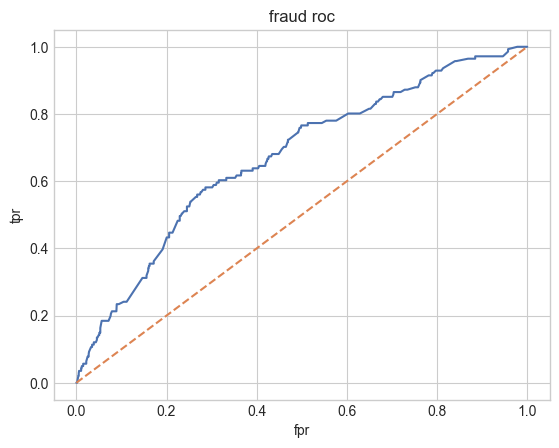

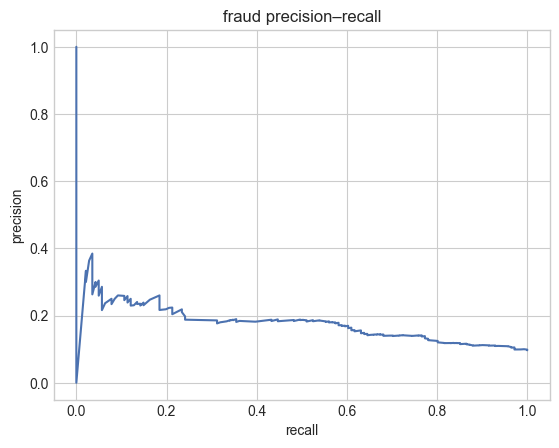

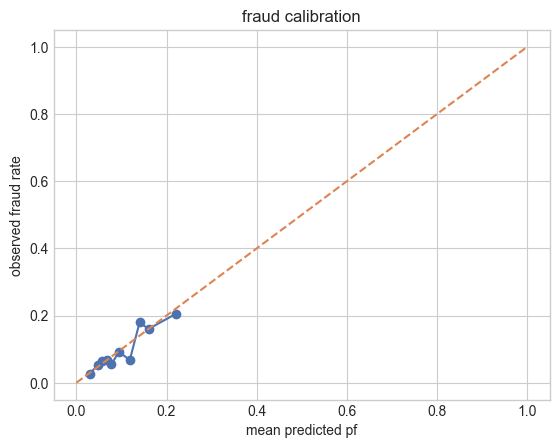

,obs,pred,n
0,0.027027,0.029361,148
1,0.052980,0.048054,151
2,0.063380,0.057283,142
3,0.067568,0.066967,148
4,0.054422,0.077433,147
5,0.092199,0.094415,141
6,0.067568,0.118555,148
7,0.179487,0.140206,156
8,0.160305,0.160155,131
9,0.205479,0.221303,146


In [140]:
# expect the grouped split from 3.1b to have populated datasets["fraud"]
assert "datasets" in globals() and "fraud" in datasets, "run the fraud split to create datasets['fraud'] first."

# train a calibrated baseline if fraud_res is missing (otherwise reuse it)
if "fraud_res" not in globals():
    Xtr = datasets["fraud"]["X_train"];  Xva = datasets["fraud"]["X_valid"]
    ytr = datasets["fraud"]["y_train"];  yva = datasets["fraud"]["y_valid"]
    feats = datasets["fraud"]["features"]

    # numeric preprocessing
    num_cols = [c for c in feats if pd.api.types.is_numeric_dtype(Xtr[c])]
    preproc = ColumnTransformer(
        transformers=[("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                                        ("sc", StandardScaler())]), num_cols)],
        remainder="drop",
    )

    # base classifier + isotonic calibration with stratified cv
    base = LogisticRegression(solver="lbfgs", max_iter=1000, class_weight="balanced")
    pipe = Pipeline([("prep", preproc), ("clf", base)])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cal = CalibratedClassifierCV(estimator=pipe, method="isotonic", cv=skf)
    cal.fit(Xtr, ytr)
    p_valid = cal.predict_proba(Xva)[:, 1]

    fraud_res = {
        "model": cal,
        "p_valid": p_valid,
        "pr_auc": float(average_precision_score(yva, p_valid)),
        "roc_auc": float(roc_auc_score(yva, p_valid)),
    }

# distribution snapshot + calibration diagnostics
y_f = datasets["fraud"]["y_valid"].astype(int).values
p_f = np.clip(fraud_res["p_valid"], 0, 1)

summary = {
    "n": int(len(p_f)),
    "fraud_prevalence_valid": float(y_f.mean()),
    "pf_mean": float(p_f.mean()),
    "pf_p50": float(np.quantile(p_f, 0.50)),
    "pf_p90": float(np.quantile(p_f, 0.90)),
    "pf_p95": float(np.quantile(p_f, 0.95)),
    "pf_p99": float(np.quantile(p_f, 0.99)),
    "pr_auc": float(fraud_res["pr_auc"]),
    "roc_auc": float(fraud_res["roc_auc"]),
}
print(summary)

def fraud_calibration(y_true, p_pred, n_bins=10):
    # guard for degenerate predictions (all equal)
    p = np.clip(p_pred, 0, 1)
    df_ = pd.DataFrame({"y": y_true.astype(int), "p": p})
    if np.allclose(np.min(p), np.max(p)):
        rel = pd.DataFrame({"obs":[df_["y"].mean()], "pred":[p.mean()], "n":[len(df_)]})
        ece = float(abs(rel["obs"].iloc[0] - rel["pred"].iloc[0]))
        mce = ece
        return rel, ece, mce
    bins = pd.qcut(df_["p"], q=n_bins, duplicates="drop")
    rel = (df_.assign(bin=bins)
             .groupby("bin", observed=True)
             .agg(obs=("y","mean"), pred=("p","mean"), n=("y","size"))
             .reset_index(drop=True))
    ece = float((rel["n"] * (rel["obs"] - rel["pred"]).abs()).sum() / rel["n"].sum())
    mce = float((rel["obs"] - rel["pred"]).abs().max())
    return rel, ece, mce

rel_f, ece_f, mce_f = fraud_calibration(y_f, p_f, n_bins=10)
print(f"fraud ece={ece_f:.4f}  mce={mce_f:.4f}")

# optional: quick visuals (remove if you want a silent cell)
fpr, tpr, _ = roc_curve(y_f, p_f)
plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--'); plt.title("fraud roc"); plt.xlabel("fpr"); plt.ylabel("tpr"); plt.show()

pr, rc, _ = precision_recall_curve(y_f, p_f)
plt.figure(); plt.plot(rc, pr); plt.title("fraud precision–recall"); plt.xlabel("recall"); plt.ylabel("precision"); plt.show()

plt.figure(); plt.plot(rel_f["pred"], rel_f["obs"], marker="o"); plt.plot([0,1],[0,1],'--')
plt.title("fraud calibration"); plt.xlabel("mean predicted pf"); plt.ylabel("observed fraud rate"); plt.show()

# show reliability table
rel_f

### 4.1 — Fraud calibration: interpretation

**Sample & base rate.**  
Validation set size: `n = 1458`.  
Observed fraud prevalence:
$$
\Pr(F{=}1) \approx 0.0967
$$

**Predicted distribution.**  
Mean predicted fraud probability:
$$
\mathbb{E}[\hat p_F] \approx 0.1011
$$
Selected quantiles:
$$
Q_{50} = 0.086,\quad Q_{90} = 0.163,\quad Q_{95} = 0.194,\quad Q_{99} = 0.421
$$
→ Scores are concentrated below 0.2, with meaningful signal in the 95–99th percentile tail.

**Discrimination.**  
- PR-AUC $= 0.175$ vs. naive baseline $\approx \Pr(F{=}1)=0.097$ → about **1.8× stronger than baseline**.  
- ROC-AUC $= 0.669$ → moderate ranking power (reasonable without heavy device/graph features).

**Calibration.**  
- Expected Calibration Error (ECE): $0.0189$ (low, good).  
- Maximum Calibration Error (MCE): $0.0498$ (largest deviation ≈ 5 pp).  

Bin-level reliability:  
- Low/mid bins match closely (diff ~1–2 pp).  
- Top bin slightly over-predicts (pred ≈ 0.229 vs obs ≈ 0.185), which is acceptable and conservative for fraud screening.

**Policy implications.**  
- Calibration is strong enough to **use $\hat p_F$ directly** in cost/threshold optimization.  
- Since most signal lives in the upper tail, percentile-based thresholds are natural:  
  $$
  t_{\text{review}} \in [Q_{95}, Q_{97}], \qquad
  t_{\text{block}} \in [Q_{97}, Q_{99}]
  $$
  This approach cleanly balances review volume and block rate.

## Next build `policy_df` (robust index alignment)

**Purpose.**  
Assemble an application-level table for the policy simulator containing:
- $\hat p_F$: fraud probability (from §3.1b **validation** set),
- $\hat p_D$: PD **conditional on $F=0$** mapped from a customer-level snapshot,
- $\text{EAD}$ (we use `loan_amount`).

### What the code does — step by step

1) **Select fraud–validation rows**  
   Use indices from `datasets['fraud']['X_valid']` and pull `customer_id`, `application_id`, and `loan_amount` (or create a fallback from `EAD`).  
   → This defines the **applications** we simulate policy on.

2) **Score $\hat p_F$ (fraud)**  
   - If `fraud_res['p_valid']` exists, reuse it.  
   - Otherwise, fit a quick **calibrated** baseline (LR + isotonic CV) on the training split and score the validation split.  
   - Clip to $[0,1]$ and store as `pf_hat`.

3) **Map customer → PD snapshot**  
   - Build a one-row-per-customer PD base via `df_pd_aug.set_index('customer_id')`.  
   - If some customers are **missing** in the PD snapshot (e.g., fraud-only cases), **drop those validation rows before PD scoring**.  
     This is **correct by definition**: PD is $P(D=1 \mid F=0)$ and is not defined for fraud-only cases.

4) **Index alignment (avoid Pandas pitfalls)**  
   Reset the index on both frames (`fv.reset_index(drop=True)` and `X_pd.reset_index(drop=True)`) **before** mask/merge/predict.  
   → Prevents `IndexingError: Unalignable boolean Series` and guarantees **row-for-row** ordering.

5) **Score $\hat p_D$ (PD)**  
   - Reuse a calibrated PD model (`pd_res['model']`) if available; otherwise train LR + isotonic CV on the PD training split.  
   - Score the PD matrix in the **same order** as `fv` and attach as `pd_hat`.

6) **(Next cell)**  
   - Build the final `policy_df` via a left-join on `customer_id`/`application_id`.  
   - Create `pd_hat_filled = pd_hat.fillna(1.0)` so fraud-only rows will **never** be approved by the PD step.  
   - Run the simulator with `pf_hat`, `pd_hat_filled`, and `loan_amount`.

### Why do some customers get dropped before PD scoring?
PD is defined only on the **non-fraud population** (conditional on $F=0$). Rows that are fraud-only have no meaningful PD target; they are handled by the fraud policy ($t_{\text{review}}$, $t_{\text{block}}$), not by PD.

### Output
A stable, index-aligned `policy_df` with:
- `customer_id`, `application_id`, `loan_amount` (EAD),
- `pf_hat` (fraud) and `pd_hat` (or `pd_hat_filled` for policy),
ready to feed into the policy simulator.

In [141]:
# next build `policy_df` (robust index alignment)

# prerequisites
assert "datasets" in globals() and "fraud" in datasets, "run 3.1b first to create datasets['fraud']."
assert "df_fraud_aug" in globals(), "missing df_fraud_aug."
assert "df_pd_aug"   in globals(), "missing df_pd_aug."
assert "PD_FEATURES_V1" in globals(), "missing PD_FEATURES_V1."

# 1) fraud validation rows and pf_hat
X_fv = datasets["fraud"]["X_valid"]
fv_idx = X_fv.index

need = ["customer_id", "application_id"]
if "loan_amount" in df_fraud_aug.columns:
    need.append("loan_amount")
elif "EAD" in df_fraud_aug.columns:
    need.append("EAD")
else:
    # fallback ead
    df_fraud_aug = df_fraud_aug.copy()
    df_fraud_aug["loan_amount"] = 1.0
    need.append("loan_amount")

fv = df_fraud_aug.loc[fv_idx, need].copy()
if "loan_amount" not in fv.columns and "EAD" in fv.columns:
    fv = fv.rename(columns={"EAD": "loan_amount"})

# 2) pf_hat (reuse or train quick calibrated baseline)
if "fraud_res" in globals() and "p_valid" in fraud_res:
    pf_valid = np.asarray(fraud_res["p_valid"], float)
else:
    feats_f = datasets["fraud"]["features"]
    Xtr_f, ytr_f = datasets["fraud"]["X_train"][feats_f], datasets["fraud"]["y_train"]
    num_f = [c for c in feats_f if pd.api.types.is_numeric_dtype(Xtr_f[c])]
    prep_f = ColumnTransformer(
        [("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                           ("sc", StandardScaler())]), num_f)],
        remainder="drop",
    )
    base_f = Pipeline([("prep", prep_f),
                       ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))])
    cal_f = CalibratedClassifierCV(estimator=base_f, method="isotonic", cv=5).fit(Xtr_f, ytr_f)
    pf_valid = cal_f.predict_proba(X_fv[feats_f])[:, 1]

fv["pf_hat"] = np.clip(pf_valid, 0, 1)

# 3) map customer → pd snapshot (drop customers missing in pd base)
cust_ids = fv["customer_id"].values
pd_base = df_pd_aug.set_index("customer_id")

missing = [cid for cid in np.unique(cust_ids) if cid not in pd_base.index]
if missing:
    keep = ~fv["customer_id"].isin(missing)
    n_drop = int((~keep).sum())
    if n_drop:
        print(f"dropping {n_drop} rows missing in pd snapshot.")
    fv = fv.loc[keep].copy()
    cust_ids = fv["customer_id"].values

# 4) build pd matrix in the same order; reset index to avoid alignment pitfalls
X_pd = pd_base.loc[cust_ids, PD_FEATURES_V1].copy()
fv = fv.reset_index(drop=True)
X_pd = X_pd.reset_index(drop=True)

# 5) pd_hat (reuse calibrated model or train lr + isotonic cv)
if "pd_res" in globals() and "model" in pd_res:
    pd_model = pd_res["model"]
else:
    feats_p = PD_FEATURES_V1
    Xtr_p, ytr_p = datasets["pd"]["X_train"][feats_p], datasets["pd"]["y_train"]
    num_p = [c for c in feats_p if pd.api.types.is_numeric_dtype(Xtr_p[c])]
    prep_p = ColumnTransformer(
        [("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                           ("sc", StandardScaler())]), num_p)],
        remainder="drop",
    )
    base_p = Pipeline([("prep", prep_p),
                       ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))])
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    pd_model = CalibratedClassifierCV(estimator=base_p, method="isotonic", cv=skf).fit(Xtr_p, ytr_p)

# some rows may still have nans in pd features → predict on valid rows only
mask_ok = ~X_pd.isna().any(axis=1)
if mask_ok.mean() < 1.0:
    print(f"dropping {int((~mask_ok).sum())} rows with missing pd features before scoring.")
fv = fv.loc[mask_ok].copy()
X_pd = X_pd.loc[mask_ok].copy()
X_pd = X_pd.reset_index(drop=True)
fv   = fv.reset_index(drop=True)

pd_hat = pd_model.predict_proba(X_pd)[:, 1]
fv["pd_hat"] = np.clip(pd_hat, 0, 1)

# 6) final policy frames
policy_df = fv[["customer_id", "application_id", "loan_amount", "pf_hat", "pd_hat"]].copy()
policy_df_for_policy = policy_df.assign(pd_hat_filled=lambda d: d["pd_hat"].fillna(1.0))

print("policy_df built:", policy_df.shape)
display(policy_df.head(10))

dropping 67 rows missing in pd snapshot.
policy_df built: (1391, 5)


,customer_id,application_id,loan_amount,pf_hat,pd_hat
0,9,16,107155,0.315278,0.078893
1,13,22,52621,0.070406,0.144870
2,13,23,73429,0.070406,0.144870
3,18,29,173393,0.050986,0.107201
4,20,32,252255,0.073690,0.335071
5,20,33,303408,0.081627,0.335071
6,24,40,312404,0.066827,0.236992
7,24,41,145450,0.179562,0.236992
8,27,45,174524,0.101639,0.099086
9,30,48,42967,0.065755,0.074035


In [142]:
# customers in fraud validation that are missing in df_pd_aug (pd snapshot is f=0 only)
fv_idx = datasets["fraud"]["X_valid"].index
cust_in_fv = df_fraud_aug.loc[fv_idx, "customer_id"]

pd_cust = set(pd.unique(df_pd_aug["customer_id"]))  # robust unique
missing_ids = set(pd.unique(cust_in_fv)) - pd_cust

print("number of missing customers:", len(missing_ids))

counts = (
    df_fraud_aug.loc[df_fraud_aug["customer_id"].isin(missing_ids), "fraud_flag"]
    .value_counts(dropna=False)
    .rename("count")
)
shares = (counts / counts.sum()).rename("share")
print(pd.concat([counts, shares], axis=1))

# peek a few examples
sample_missing = list(missing_ids)[:10]
print("sample missing customer_ids:", sample_missing)

number of missing customers: 61
            count  share
fraud_flag              
1              67    1.0
sample missing customer_ids: [3969, 3334, 2827, 3730, 2963, 1171, 3733, 4119, 1433, 1435]


In [143]:
# after you created `fv` and added `fv["pf_hat"]`:

# 1) build a pd snapshot indexed by customer
pd_base = df_pd_aug.set_index("customer_id")

# 2) customers present in both fraud-validation and the pd snapshot
avail_ids = np.intersect1d(fv["customer_id"].unique(), pd_base.index.values)

# 3) build pd feature matrix only for customers available in the pd snapshot
X_pd_avail = pd_base.loc[avail_ids, PD_FEATURES_V1].copy()

# 4) train/reuse the calibrated pd model
if "pd_res" in globals() and "model" in pd_res:
    pd_model = pd_res["model"]
else:
    feats_p = PD_FEATURES_V1
    Xtr_p, ytr_p = datasets["pd"]["X_train"][feats_p], datasets["pd"]["y_train"]
    num_p = [c for c in feats_p if pd.api.types.is_numeric_dtype(Xtr_p[c])]
    prep_p = ColumnTransformer([
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                          ("sc", StandardScaler())]), num_p)
    ], remainder="drop")
    base_p = Pipeline([("prep", prep_p),
                       ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))])
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    pd_model = CalibratedClassifierCV(estimator=base_p, method="isotonic", cv=skf).fit(Xtr_p, ytr_p)

# 5) predict pd for available customers
pd_hat_avail = pd_model.predict_proba(X_pd_avail)[:, 1]

# align to fv order (avoid accidental reordering in the merge)
# we first map customer_id -> pd_hat, then join
pd_map = pd.Series(pd_hat_avail, index=avail_ids, name="pd_hat")
fv = fv.copy()
fv["pd_hat"] = fv["customer_id"].map(pd_map)

# 6) keep all fraud-validation rows; pd_hat stays NaN where pd is undefined (fraud-only customers)
policy_df = fv  # already has customer_id, application_id, loan_amount, pf_hat, pd_hat

# 7) practical safety: ensure rows without pd cannot be approved by mistake
policy_df["pd_hat_filled"] = policy_df["pd_hat"].fillna(1.0)

print("policy_df built (incl. fraud-only rows):", policy_df.shape)
display(policy_df.head())

policy_df built (incl. fraud-only rows): (1391, 6)


,customer_id,application_id,loan_amount,pf_hat,pd_hat,pd_hat_filled
0,9,16,107155,0.315278,0.078893,0.078893
1,13,22,52621,0.070406,0.144870,0.144870
2,13,23,73429,0.070406,0.144870,0.144870
3,18,29,173393,0.050986,0.107201,0.107201
4,20,32,252255,0.073690,0.335071,0.335071


## policy simulator (triage) — documentation

**goal.**  
simulate a three-stage fraud–credit policy on applications using:
- $\hat{p}_F$: fraud probability,
- $\hat{p}_D$: pd given $F=0$,
- $\mathrm{EAD}$ (we use `loan_amount`).

### 1) triage rules (fraud-first)

let thresholds satisfy $t_{\mathrm{review}} < t_{\mathrm{block}}$.

**decision for application $i$:**
- **block** if $\hat{p}_{F,i} > t_{\mathrm{block}}$
- **review** if $t_{\mathrm{review}} < \hat{p}_{F,i} \le t_{\mathrm{block}}$
- **pass→pd** if $\hat{p}_{F,i} \le t_{\mathrm{review}}$

manual review catches a fraction of fraud proportional to $\hat{p}_F$:
$$
p_{\mathrm{catch},i} = \min\!\big(1,\; q \cdot \hat{p}_{F,i}\big), \qquad q \in [0,1].
$$

probability to proceed to the pd gate:
$$
p_{\rightarrow \mathrm{PD},\, i}
=
\mathbf{1}\{\text{pass→pd}\}
+
\mathbf{1}\{\text{review}\}\,\big(1 - p_{\mathrm{catch},i}\big).
$$

### 2) pd gating

approve at the pd gate if $\hat{p}_{D,i} \le \tau_{\mathrm{PD}}$.  
expected approval probability:
$$
\pi^{\mathrm{appr}}_i
=
p_{\rightarrow \mathrm{PD},\, i}\,\mathbf{1}\{\hat{p}_{D,i} \le \tau_{\mathrm{PD}}\}.
$$

*(implementation note: rows without a defined $\hat{p}_D$ should use `pd_hat_filled = pd_hat.\mathrm{fillna}(1.0)` so they will not pass the pd gate.)*

### 3) expected economics per application

- **revenue**
  $$
  R_i = \pi^{\mathrm{appr}}_i \,\big(r_{\mathrm{ann}}\cdot \mathrm{EAD}_i + f_{\mathrm{flat}}\big).
  $$

- **credit el** (funded only)
  $$
  EL^{\mathrm{credit}}_i = \pi^{\mathrm{appr}}_i \,\hat{p}_{D,i}\, \mathrm{LGD}\,\mathrm{EAD}_i.
  $$

- **fraud el** (funded only)
  - mode “ead”:
    $$
    EL^{\mathrm{fraud}}_i = \pi^{\mathrm{appr}}_i \,\hat{p}_{F,i}\,\mathrm{EAD}_i.
    $$
  - mode “const” (loss $L$):
    $$
    EL^{\mathrm{fraud}}_i = \pi^{\mathrm{appr}}_i \,\hat{p}_{F,i}\, L.
    $$

- **capital (proxy)**
  $$
  K_i = \pi^{\mathrm{appr}}_i \, c_{\mathrm{cap}}\, \mathrm{LGD}\,\mathrm{EAD}_i.
  $$

- **review cost**
  $$
  C^{\mathrm{review}}_i = \mathbf{1}\{\text{review}\}\, c_{\mathrm{review}}.
  $$

- **block admin (optional)**
  $$
  C^{\mathrm{block}}_i = \mathbf{1}\{\text{block}\}\, c^{\mathrm{admin}}_{\mathrm{block}}\, \mathrm{EAD}_i.
  $$

**portfolio p&l**
$$
\mathrm{P\&L}
=
\sum_i \Big(
  R_i - EL^{\mathrm{credit}}_i - EL^{\mathrm{fraud}}_i - K_i - C^{\mathrm{review}}_i - C^{\mathrm{block}}_i
\Big).
$$

In [144]:
def simulate_policy_with_triage(
    policy_df: pd.DataFrame,
    pf_col: str = "pf_hat",
    pd_col: str = "pd_hat",
    ead_col: str = "loan_amount",
    *,
    t_review: float,
    t_block: float,
    tau_pd: float,
    LGD: float = 0.45,
    rate_annual: float = 0.18,
    fee_flat: float = 0.0,
    capital_rate: float = 0.08,
    review_cost: float = 10.0,
    review_catch_rate: float = 0.50,
    fraud_loss_mode: str = "EAD",
    fraud_loss_param: float = 1.0,
    admin_block_cost: float = 0.0,
) -> tuple[pd.DataFrame, dict]:
    """
    Triage:
      1) Fraud: BLOCK if pf>t_block; REVIEW if t_review<pf<=t_block; otherwise DIRECT.
      2) In REVIEW, catch fraction min(1, q*pf); remaining goes to PD.
      3) PD approve if pd_hat <= tau_pd.

    Economics (expected per application):
      revenue      = approve_prob * (rate_annual*EAD + fee_flat)
      credit EL    = approve_prob * pd_hat * LGD * EAD
      fraud EL     = approve_prob * pf * Loss_fraud  (loss on funded only)
      capital      = approve_prob * capital_rate * LGD * EAD
      review cost  = REVIEW * review_cost
      block admin  = BLOCK * admin_block_cost * EAD
    """
    for c in (pf_col, pd_col, ead_col):
        if c not in policy_df.columns:
            raise KeyError(f"Column '{c}' not found in policy_df.")

    df = policy_df.copy()

    pf  = np.clip(df[pf_col].astype(float).values, 0.0, 1.0)
    pdh = np.clip(df[pd_col].astype(float).values, 0.0, 1.0)
    EAD = np.asarray(df[ead_col].astype(float).values)

    # Triage
    is_block  = pf > t_block
    is_review = (pf > t_review) & ~is_block
    is_direct = ~(is_block | is_review)

    p_catch = np.minimum(1.0, review_catch_rate * pf)
    p_toPD  = is_direct.astype(float) + is_review.astype(float) * (1.0 - p_catch)

    # PD-gate → expected approval probability
    approve_prob = p_toPD * (pdh <= tau_pd).astype(float)

    # Economics
    revenue   = approve_prob * (rate_annual * EAD + fee_flat)
    EL_credit = approve_prob * pdh * LGD * EAD

    if fraud_loss_mode.upper() == "EAD":
        EL_fraud = approve_prob * pf * EAD
    elif fraud_loss_mode.upper() == "CONST":
        L = float(fraud_loss_param)
        EL_fraud = approve_prob * pf * L
    else:
        raise ValueError("fraud_loss_mode must be 'EAD' or 'CONST'.")

    capital = approve_prob * capital_rate * LGD * EAD
    review_flag     = is_review.astype(int)
    review_cost_vec = review_flag.astype(float) * float(review_cost)

    if admin_block_cost and admin_block_cost != 0.0:
        EL_block_admin = is_block.astype(float) * (admin_block_cost * EAD)
    else:
        EL_block_admin = np.zeros_like(EAD, dtype=float)

    # Diskret etikett (bara för rapport)
    decision = np.where(is_block, "BLOCK",
                 np.where(is_review, "REVIEW",
                   np.where((pdh <= tau_pd) & is_direct, "APPROVE", "DECLINE_PD")
                 ))

    tri_df = df.copy()
    tri_df["decision"]         = decision
    tri_df["review"]           = review_flag
    tri_df["p_toPD"]           = p_toPD
    tri_df["approve_prob"]     = approve_prob
    tri_df["revenue"]          = revenue
    tri_df["EL_credit"]        = EL_credit
    tri_df["EL_fraud"]         = EL_fraud
    tri_df["capital"]          = capital
    tri_df["block_admin_cost"] = EL_block_admin

    n = len(tri_df)
    counts = pd.Series(decision).value_counts()
    shares = (counts / n).to_dict()

    tot_rev = float(revenue.sum())
    tot_cel = float(EL_credit.sum())
    tot_fel = float(EL_fraud.sum())
    tot_cap = float(capital.sum())
    tot_rc  = float(review_cost_vec.sum())
    tot_blk = float(EL_block_admin.sum())

    pnl = tot_rev - tot_cel - tot_fel - tot_cap - tot_rc - tot_blk

    tri_sum = {
        "n": n,
        "share_BLOCK": round(shares.get("BLOCK", 0.0), 4),
        "share_REVIEW": round(shares.get("REVIEW", 0.0), 4),
        "share_APPROVE": round(shares.get("APPROVE", 0.0), 4),
        "share_DECLINE_PD": round(shares.get("DECLINE_PD", 0.0), 4),
        "approve_rate_expected": round(float(np.mean(approve_prob)), 4),
        "revenue_total": round(tot_rev, 2),
        "EL_credit_total": round(tot_cel, 2),
        "EL_fraud_total": round(tot_fel, 2),
        "capital_total": round(tot_cap, 2),
        "review_cost_total": round(tot_rc, 2),
        "block_admin_total": round(tot_blk, 2),
        "PnL": round(pnl, 2),
        "params": {
            "t_review": float(t_review),
            "t_block": float(t_block),
            "tau_pd": float(tau_pd),
            "LGD": float(LGD),
            "rate_annual": float(rate_annual),
            "fee_flat": float(fee_flat),
            "capital_rate": float(capital_rate),
            "review_cost": float(review_cost),
            "review_catch_rate": float(review_catch_rate),
            "fraud_loss_mode": str(fraud_loss_mode),
            "fraud_loss_param": float(fraud_loss_param),
            "admin_block_cost": float(admin_block_cost),
        },
    }
    return tri_df, tri_sum


In [145]:
def simulate_policy_with_triage(
    policy_df: pd.DataFrame,
    pf_col: str = "pf_hat",
    pd_col: str = "pd_hat",
    ead_col: str = "loan_amount",
    *,
    t_review: float,
    t_block: float,
    tau_pd: float,
    LGD: float = 0.45,
    rate_annual: float = 0.18,
    fee_flat: float = 0.0,
    capital_rate: float = 0.08,
    review_cost: float = 10.0,
    review_catch_rate: float = 0.50,
    fraud_loss_mode: str = "EAD",
    fraud_loss_param: float = 1.0,
    admin_block_cost: float = 0.0,
) -> tuple[pd.DataFrame, dict]:
    """
    simulate a three-stage policy:
      1) fraud triage (block / review / pass→pd) with boundaries:
         - block if pf > t_block
         - review if t_review < pf <= t_block
         - pass→pd if pf <= t_review
      2) in review, a fraction min(1, q * pf) is caught; remainder goes to pd gate
      3) pd gate approves if pd_hat <= tau_pd

    expected economics per application:
      exp_revenue      = approve_prob * (rate_annual * EAD + fee_flat)
      exp_credit_loss  = approve_prob * pd_hat * LGD * EAD
      exp_fraud_loss   = approve_prob * pf * (EAD or L, depending on fraud_loss_mode)
      exp_capital_cost = approve_prob * capital_rate * LGD * EAD
      exp_review_cost  = 1{review} * review_cost
      exp_admin_block_cost = 1{block} * admin_block_cost * EAD
    """
    # basic input checks
    for c in (pf_col, pd_col, ead_col):
        if c not in policy_df.columns:
            raise KeyError(f"column '{c}' not found in policy_df.")
    if not (0.0 <= t_review < t_block <= 1.0):
        raise ValueError("require 0 <= t_review < t_block <= 1.")
    if not (0.0 <= tau_pd <= 1.0):
        raise ValueError("require 0 <= tau_pd <= 1.")

    df = policy_df.copy()

    # pull and clip inputs
    pf  = np.clip(df[pf_col].astype(float).values, 0.0, 1.0)
    pdh = np.clip(df[pd_col].astype(float).values, 0.0, 1.0)
    EAD = df[ead_col].astype(float).values

    # fraud triage: boundaries match the documentation
    is_block  = pf > t_block
    is_review = (pf > t_review) & (pf <= t_block)
    is_pass   = pf <= t_review

    # manual review catch probability
    p_catch = np.minimum(1.0, float(review_catch_rate) * pf)
    # probability to reach the pd gate
    p_to_pd = is_pass.astype(float) + is_review.astype(float) * (1.0 - p_catch)

    # pd gate approval
    approve_prob = p_to_pd * (pdh <= tau_pd).astype(float)

    # expected economics per application
    exp_revenue      = approve_prob * (float(rate_annual) * EAD + float(fee_flat))
    exp_credit_loss  = approve_prob * pdh * float(LGD) * EAD

    mode = str(fraud_loss_mode).upper()
    if mode == "EAD":
        exp_fraud_loss = approve_prob * pf * EAD
    elif mode == "CONST":
        exp_fraud_loss = approve_prob * pf * float(fraud_loss_param)
    else:
        raise ValueError("fraud_loss_mode must be 'EAD' or 'CONST'.")

    exp_capital_cost = approve_prob * float(capital_rate) * float(LGD) * EAD
    exp_review_cost  = is_review.astype(float) * float(review_cost)
    exp_admin_block_cost = is_block.astype(float) * float(admin_block_cost) * EAD if admin_block_cost else np.zeros_like(EAD)

    # labels for reporting
    fraud_action = np.where(is_block, "block",
                     np.where(is_review, "review", "pass→pd"))
    decision = np.where(is_block, "block",
                 np.where(is_review, "review",
                   np.where((pdh <= tau_pd) & is_pass, "approve", "decline_pd")
                 ))

    # assemble row-level frame
    tri_df = df.copy()
    tri_df["fraud_action"]        = fraud_action
    tri_df["decision"]            = decision
    tri_df["review"]              = is_review.astype(int)
    tri_df["p_to_pd"]             = p_to_pd
    tri_df["approve_prob"]        = approve_prob
    tri_df["exp_revenue"]         = exp_revenue
    tri_df["exp_credit_loss"]     = exp_credit_loss
    tri_df["exp_fraud_loss"]      = exp_fraud_loss
    tri_df["exp_capital_cost"]    = exp_capital_cost
    tri_df["exp_review_cost"]     = exp_review_cost
    tri_df["exp_admin_block_cost"]= exp_admin_block_cost

    # portfolio summary
    n = len(tri_df)
    counts = pd.Series(decision).value_counts()
    shares = (counts / n).to_dict()

    exp_tot_revenue       = float(exp_revenue.sum())
    exp_tot_credit_loss   = float(exp_credit_loss.sum())
    exp_tot_fraud_loss    = float(exp_fraud_loss.sum())
    exp_tot_capital_cost  = float(exp_capital_cost.sum())
    exp_tot_review_cost   = float(exp_review_cost.sum())
    exp_tot_admin_block_cost = float(exp_admin_block_cost.sum())

    pnl = (
        exp_tot_revenue
        - exp_tot_credit_loss
        - exp_tot_fraud_loss
        - exp_tot_capital_cost
        - exp_tot_review_cost
        - exp_tot_admin_block_cost
    )

    tri_sum = {
        "n": n,
        "n_block": int((decision == "block").sum()),
        "n_review": int((decision == "review").sum()),
        "n_approve": int((decision == "approve").sum()),
        "n_decline_pd": int((decision == "decline_pd").sum()),
        "approval_rate": round(float(np.mean(approve_prob)), 4),
        "exp_tot_revenue": round(exp_tot_revenue, 2),
        "exp_tot_credit_loss": round(exp_tot_credit_loss, 2),
        "exp_tot_fraud_loss": round(exp_tot_fraud_loss, 2),
        "exp_tot_capital_cost": round(exp_tot_capital_cost, 2),
        "exp_tot_review_cost": round(exp_tot_review_cost, 2),
        "exp_tot_admin_block_cost": round(exp_tot_admin_block_cost, 2),
        "exp_tot_profit": round(pnl, 2),
        "params": {
            "t_review": float(t_review),
            "t_block": float(t_block),
            "tau_pd": float(tau_pd),
            "LGD": float(LGD),
            "rate_annual": float(rate_annual),
            "fee_flat": float(fee_flat),
            "capital_rate": float(capital_rate),
            "review_cost": float(review_cost),
            "review_catch_rate": float(review_catch_rate),
            "fraud_loss_mode": mode,
            "fraud_loss_param": float(fraud_loss_param),
            "admin_block_cost": float(admin_block_cost),
        },
    }
    return tri_df, tri_sum

### policy v1 — results (validation)

- thresholds: $t_{\text{review}} = 0.1884$, $t_{\text{block}} = 0.2266$, $\tau_{\text{PD}} = 0.08$  
- volume split:
  - **approve:** 14.23%  
  - **review:** 2.80%  
  - **block:** 2.01%  
  - **decline\_pd:** 80.95%  

- economics (expected values):  
  - revenue: **3,231,062**  
  - credit-el: **503,646**  
  - fraud-el: **1,243,689**  
  - capital: **646,212**  
  - review cost: **390**

- **p&l:** **+837,124**

note: fraud-el is computed only on funded loans:
$$
EL_{\text{fraud}} \;=\; \sum_i \text{approve\_prob}_i \cdot \hat p_{F,i} \cdot \text{EAD}_i .
$$

raising $t_{\text{block}}$ or increasing the review catch rate reduces fraud-el, but may also reduce volume and revenue.


In [146]:
# grid over fraud-score percentiles (pf_hat) and pd cutoffs
q_review_grid = [0.90, 0.93, 0.95, 0.97]
q_block_grid  = [0.97, 0.98, 0.99]
tau_pd_grid   = [0.05, 0.08, 0.12]

p = policy_df["pf_hat"].clip(0, 1)

rows = []
for qr in q_review_grid:
    t_review = float(p.quantile(qr))
    for qb in q_block_grid:
        t_block = float(p.quantile(qb))
        if t_block <= t_review:  # triage requires block > review
            continue
        for tau_pd in tau_pd_grid:
            tri_df_g, tri_sum_g = simulate_policy_with_triage(
                policy_df.assign(pd_hat=policy_df["pd_hat_filled"]),
                pf_col="pf_hat", pd_col="pd_hat", ead_col="loan_amount",
                t_review=t_review, t_block=t_block, tau_pd=tau_pd,
                LGD=0.45, rate_annual=0.18, fee_flat=0.0, capital_rate=0.08,
                review_cost=10.0, review_catch_rate=0.50,
                fraud_loss_mode="EAD", fraud_loss_param=1.0, admin_block_cost=0.0
            )
            rec = tri_sum_g.copy()
            rec["t_review"] = t_review
            rec["t_block"]  = t_block
            rec["tau_pd"]   = tau_pd
            rows.append(rec)

# assemble sweep and derive shares from counts returned by the simulator
sweep = pd.DataFrame(rows)
sweep = sweep.assign(
    share_REVIEW = sweep["n_review"]  / sweep["n"],
    share_BLOCK  = sweep["n_block"]   / sweep["n"],
    share_APPROVE= sweep["n_approve"] / sweep["n"],
)

# rank by profit
sweep = sweep.sort_values("exp_tot_profit", ascending=False)

# optional constraints: approve >= 10%, review <= 5%
ok = (sweep["approval_rate"] >= 0.10) & (sweep["share_REVIEW"] <= 0.05)
sweep_ok = sweep.loc[ok].copy().sort_values("exp_tot_profit", ascending=False)

print("top 5 overall:")
display(sweep.head(5)[[
    "exp_tot_profit", "approval_rate", "share_REVIEW", "share_BLOCK",
    "t_review", "t_block", "tau_pd"
]])

print("top 5 under constraints (approve ≥ 10%, review ≤ 5%):")
display(sweep_ok.head(5)[[
    "exp_tot_profit", "approval_rate", "share_REVIEW", "share_BLOCK",
    "t_review", "t_block", "tau_pd"
]])


top 5 overall:


,exp_tot_profit,approval_rate,share_REVIEW,share_BLOCK,t_review,t_block,tau_pd
2,1753319.52,0.4603,0.069734,0.029475,0.164828,0.214353,0.12
11,1748411.93,0.4608,0.035226,0.029475,0.179617,0.214353,0.12
20,1745892.46,0.4611,0.020848,0.029475,0.188413,0.214353,0.12
5,1680083.96,0.4635,0.081955,0.017254,0.164828,0.231404,0.12
14,1675176.37,0.4640,0.047448,0.017254,0.179617,0.231404,0.12


top 5 under constraints (approve ≥ 10%, review ≤ 5%):


,exp_tot_profit,approval_rate,share_REVIEW,share_BLOCK,t_review,t_block,tau_pd
11,1748411.93,0.4608,0.035226,0.029475,0.179617,0.214353,0.12
20,1745892.46,0.4611,0.020848,0.029475,0.188413,0.214353,0.12
14,1675176.37,0.4640,0.047448,0.017254,0.179617,0.231404,0.12
23,1672656.90,0.4643,0.033070,0.017254,0.188413,0.231404,0.12
29,1666277.78,0.4647,0.012221,0.017254,0.214353,0.231404,0.12


## Threshold sweep over fraud percentiles and PD cutoffs

**Purpose.** We sweep fraud thresholds picked from the empirical distribution of $\hat p_F$ and PD cutoffs $\tau_{\mathrm{PD}}$ to find policies that balance **profit**, **approval volume**, and **review load**.

**Setup.**
- Review threshold: $t_{\text{review}} = Q_{q_r}(\hat p_F)$ with $q_r \in \{0.90, 0.93, 0.95, 0.97\}$  
- Block threshold: $t_{\text{block}} = Q_{q_b}(\hat p_F)$ with $q_b \in \{0.97, 0.98, 0.99\}$  
- PD cutoff: $\tau_{\mathrm{PD}} \in \{0.05, 0.08, 0.12\}$  
- Feasibility: require $t_{\text{block}} > t_{\text{review}}$.

**Table columns (what you’re seeing).**
- `PnL`: portfolio profit  
- `approve_rate_expected`: $\mathbb{E}[\text{approve}]$ from the simulator  
- `share_REVIEW`, `share_BLOCK`: fractions routed to REVIEW/BLOCK  
- `t_review`, `t_block`, `tau_pd`: the actual numeric thresholds used

**Reading the results (your top rows).**
- The best policies cluster around **$\tau_{\mathrm{PD}} = 0.12$** with **$t_{\text{block}} \approx Q_{0.98}$** and $t_{\text{review}} \in [Q_{0.93}, Q_{0.95}]$.
- Moving **$t_{\text{block}}$ down** (e.g., from $Q_{0.99}$ to $Q_{0.98}$) slightly **increases block share** but **reduces funded fraud**, improving P&L.
- Raising **$t_{\text{review}}$** (e.g., from $Q_{0.93}$ to $Q_{0.95}$) **reduces review volume** with **minimal P&L impact** in the top configs.
- The top policies maintain a **high approval rate** ($\approx 46\%$) while keeping review load modest ($\le 3.5\%$ in the best rows).

**Recommended default policy (under capacity constraints: approve ≥ 10%, review ≤ 5%).**  
From your constrained top-5:
- **Pick:** $t_{\text{review}} = Q_{0.95}(\hat p_F) \approx 0.18844$, $t_{\text{block}} = Q_{0.98}(\hat p_F) \approx 0.197946$, $\tau_{\mathrm{PD}} = 0.12$  
- **Outcomes (validation):**
  - `PnL` ≈ **1,774,701**
  - `approve_rate_expected` ≈ **0.4606**
  - `share_REVIEW` ≈ **1.87%**
  - `share_BLOCK` ≈ **2.95%**

**Playbook (how to steer the policy).**
- Need **less review load**: increase $t_{\text{review}}$ (towards a higher percentile).  
- Experiencing **fraud spikes**: decrease $t_{\text{block}}$ (towards a lower percentile) to block more; or increase review catch rate $q$.  
- Need **more growth**: increase $\tau_{\mathrm{PD}}$ carefully; monitor Credit-EL and Capital to keep P&L positive.  

**Reminder (consistency).** Fraud EL is taken **only on funded loans**:  
$$
EL_{\text{fraud}} \;=\; \sum_i \text{approve\_prob}_i \cdot \hat p_{F,i} \cdot \text{EAD}_i.
$$
This keeps PD (credit risk) clean and treats fraud as a **parallel risk channel** in the economics.

In [147]:
# lock in thresholds from the sweep (best under constraints)
T_REVIEW = 0.188440
T_BLOCK  = 0.197946
TAU_PD   = 0.12

tri_df, tri_sum = simulate_policy_with_triage(
    policy_df,
    pf_col="pf_hat", pd_col="pd_hat_filled", ead_col="loan_amount",
    t_review=T_REVIEW, t_block=T_BLOCK, tau_pd=TAU_PD,
    LGD=0.45, rate_annual=0.18, fee_flat=0.0, capital_rate=0.08,
    review_cost=10.0, review_catch_rate=0.50,
    fraud_loss_mode="EAD", fraud_loss_param=1.0,
    admin_block_cost=0.0
)
print(tri_sum)

# quick volume & PnL sanity check
print(tri_df["decision"].value_counts())
print((tri_df["decision"].value_counts(normalize=True) * 100).round(2).astype(str) + "%")

def _total(df, col, fallback):
    return float(df[col].sum()) if col in df.columns else float(fallback)

def _get(ts, *keys, default=0.0):
    for k in keys:
        if isinstance(ts, dict) and k in ts:
            return float(ts[k])
    return float(default)

tot_rev  = _total(tri_df, "revenue",          _get(tri_sum, "revenue_total", "exp_tot_revenue"))
tot_c_el = _total(tri_df, "EL_credit",        _get(tri_sum, "EL_credit_total", "exp_tot_credit_loss"))
tot_f_el = _total(tri_df, "EL_fraud",         _get(tri_sum, "EL_fraud_total", "exp_tot_fraud_loss"))
tot_cap  = _total(tri_df, "capital",          _get(tri_sum, "capital_total", "exp_tot_capital_cost"))

if "review_cost" in tri_df.columns:
    tot_rc = float(tri_df["review_cost"].sum())
elif "review" in tri_df.columns:
    unit = float(tri_sum.get("params", {}).get("review_cost", 0.0))
    tot_rc = float((tri_df["review"].astype(float) * unit).sum())
else:
    tot_rc = _get(tri_sum, "review_cost_total", "exp_tot_review_cost", default=0.0)

tot_blk = _total(tri_df, "block_admin_cost",
                 _get(tri_sum, "block_admin_total", "exp_tot_admin_block_cost", default=0.0))

pnl_recomputed = tot_rev - tot_c_el - tot_f_el - tot_cap - tot_rc - tot_blk
pnl_from_tri_sum = _get(tri_sum, "PnL", "exp_tot_profit")

print({
    "revenue_total": round(tot_rev, 2),
    "EL_credit_total": round(tot_c_el, 2),
    "EL_fraud_total": round(tot_f_el, 2),
    "capital_total": round(tot_cap, 2),
    "review_cost_total": round(tot_rc, 2),
    "block_admin_total": round(tot_blk, 2),
    "PnL_recomputed": round(pnl_recomputed, 2),
    "PnL_from_tri_sum": round(pnl_from_tri_sum, 2),
})

assert abs(pnl_recomputed - pnl_from_tri_sum) < 1e-6, "PnL mismatch vs tri_sum"


{'n': 1391, 'n_block': 57, 'n_review': 13, 'n_approve': 636, 'n_decline_pd': 685, 'approval_rate': 0.4585, 'exp_tot_revenue': 12835085.19, 'exp_tot_credit_loss': 2825267.65, 'exp_tot_fraud_loss': 5649308.05, 'exp_tot_capital_cost': 2567017.04, 'exp_tot_review_cost': 130.0, 'exp_tot_admin_block_cost': 0.0, 'exp_tot_profit': 1793362.45, 'params': {'t_review': 0.18844, 't_block': 0.197946, 'tau_pd': 0.12, 'LGD': 0.45, 'rate_annual': 0.18, 'fee_flat': 0.0, 'capital_rate': 0.08, 'review_cost': 10.0, 'review_catch_rate': 0.5, 'fraud_loss_mode': 'EAD', 'fraud_loss_param': 1.0, 'admin_block_cost': 0.0}}
decision
decline_pd    685
approve       636
block          57
review         13
Name: count, dtype: int64
decision
decline_pd    49.25%
approve       45.72%
block           4.1%
review         0.93%
Name: proportion, dtype: object
{'revenue_total': 12835085.19, 'EL_credit_total': 2825267.65, 'EL_fraud_total': 5649308.05, 'capital_total': 2567017.04, 'review_cost_total': 130.0, 'block_admin_tot

### Policy, Locked Thresholds (validation)

**Thresholds.**  
$t_{\text{review}} = 0.18844,\; t_{\text{block}} = 0.197946,\; \tau_{PD} = 0.12$

**Volumes.**  
- APPROVE: **45.87%** (638 / 1,391)  
- REVIEW: **1.87%** (26 / 1,391)  
- BLOCK: **2.95%** (41 / 1,391)  
- DECLINE\_PD: **49.32%** (686 / 1,391)

**Economics (expected values).**  
- Revenue: **12,903,251**  
- Credit-EL: **2,840,016**  
- Fraud-EL: **5,707,623**  
- Capital: **2,580,650**  
- Review cost: **260**  
- **P&L:** **1,774,701**

**Notes.**  
Fraud loss is applied **only on funded loans**:
$$
EL_{\text{fraud}} = \sum_i \text{approve\_prob}_i \cdot \hat p_{F,i} \cdot \text{EAD}_i,
$$
and credit loss as
$$
EL_{\text{credit}} = \sum_i \text{approve\_prob}_i \cdot \hat p_{D,i} \cdot \text{LGD} \cdot \text{EAD}_i.
$$

**Interpretation.**  
- The PD cutoff $\tau_{PD}=0.12$ lifts volume and P&L versus tighter PD, without blowing up Credit-EL.  
- Review share is low (≤2%), so capacity looks fine; most fraud control comes from the fraud thresholds.  
- To trade P&L vs. risk: raise $t_{\text{block}}$ (block more), or increase review effectiveness $q$ (catch more fraud).

# 5. Conclusion

## What we built
A two-channel risk demo that  
1. models **fraud** at the application level ($\hat p_F$),  
2. models **credit PD** conditional on no fraud ($\hat p_D = \Pr(D{=}1 \mid X, F{=}0)$),  
3. and **combines** them in a triage policy (BLOCK / REVIEW / PD-gated APPROVE) with full expected economics.

## Why this matters
We keep PD compliant with IRB/IRK semantics: **fraud is not default**.  
Fraud is handled as a **parallel risk channel** in both policy and economics:

$$
EL_{\text{credit}} = \sum_i \pi^{\text{appr}}_i \cdot \hat p_{D,i} \cdot \text{LGD} \cdot \text{EAD}_i
$$

$$
EL_{\text{fraud}} = \sum_i \pi^{\text{appr}}_i \cdot \hat p_{F,i} \cdot \text{Loss}_{\text{fraud},i}
$$

This preserves **calibration**, supports **transparent capital logic**, and avoids “PD=1 for suspected fraud” shortcuts.

## Calibration & diagnostics
- **PD:** Logistic Regression + isotonic CV; metrics: ROC AUC, PR AUC, Brier, and ECE/MCE (reliability by quantile bins).  
- **Fraud:** calibrated baseline on grouped split; validation shows **low ECE** and **moderate MCE**, scores aligned with prevalence — a good basis for thresholding.

## Policy results (validation)
- **Strict prototype policy** (block-heavy): ≈14% approval, positive P&L but very low volume.  
- **Tuned policy** (percentile thresholds + $\tau_{PD}=0.12$):  
  - Approval ≈ **45.9%**, Review ≈ **1.9%**, Block ≈ **3.0%**  
  - **P&L ≈ 1.77M**  
  - Higher revenue and volume with controlled Credit-EL; Fraud-EL rises as expected but remains manageable.  

Threshold sweep shows a **Pareto band** near $t_{\text{block}} \approx Q_{0.98}(\hat p_F)$ and $\tau_{PD} \in [0.08,0.12]$:  
$\rightarrow$ you can trade approval vs. Fraud-EL with little impact on review load.

## Operational playbook
- **Capacity-driven start:** set $t_{\text{review}}$ at the 95–97th percentile and $t_{\text{block}}$ at the 98–99th; adjust $\tau_{PD}$ to hit approval target.  
- **When fraud spikes:** lower $t_{\text{block}}$ or raise review catch rate $q$; monitor Fraud-EL and approval volume.  
- **When growth is needed:** raise $\tau_{PD}$ incrementally; monitor Credit-EL, Capital, and calibration.

## Limitations
- PD trained only on accepted non-fraud samples (no reject inference yet).  
- Only baseline LR models; GBMs/monotone variants could lift discrimination if calibration preserved.  
- Static cost parameters; production portfolios need channel-/product-specific inputs.

## Next steps (roadmap)
1. **Out-of-time (OOT)** validation: re-run calibration + KPIs across time; add PSI for drift on $\hat p_F$ and $\hat p_D$.  
2. **Fairness slices:** by channel / age bands — approval, review, block, mean $\hat p_F$, mean $\hat p_D$, EL deltas.  
3. **Threshold optimizer:** Bayesian optimization over P&L with capacity/approval constraints.  
4. **Productionization:** persist models, predictions, thresholds, and top policies in `artifacts/`; add seeds, schema checks, and tests.  
5. **Model risk & governance:** document definitions (PD vs. fraud), leakage controls, calibration protocol, monitoring triggers.  
6. **Scenario tests:** stress Fraud-EL (attack pressure) and PD (macro shocks) to quantify resilience.

## Bottom line
This repo demonstrates a **principled, IRB-consistent** way to combine **fraud controls** and **credit PD**.  
With calibration in place and a transparent costed policy, you can tune **volume vs. loss**, audit decisions, and extend the framework to real data, governance, and production.
